# <center><u>Stock Market News Sentiment Analysis and Summarization</u></center>

# <u>Importing Required Libraries</u>

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

  You can safely remove it manually.
  You can safely remove it manually.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
# nltk.download('punkt')    # loading the punkt module used in tokenization
# nltk.download('omw-1.4')    # dependency for tokenization
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix

import time
import torch
from sentence_transformers import SentenceTransformer

from huggingface_hub import hf_hub_download
from llama_cpp import Llama

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pri96\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pri96\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


***
***

# <u>Exploratory Data Analysis</u>

## Problem Definition

> Talking about the **Problem Definition** based on the business context, our task is to predict how the company’s stock prices will move based on daily news sentiment (Positive, Neutral, Negative) analysis of news articles.
> 
> * The current dataset provides sentiment labels, which serve as indicators of market mood. Our challenge is to analyze their relationship with stock prices (Open, Close, High, Low) to undertsand the actionable patterns
> * We can summarizing news at a weekly level to help us detect major trends and isolate critical positive or negative events affecting stock performance
> * Understanding correlations between stock prices (e.g., Open, Close) and sentiment label (-1, 0, 1) is essential for designing a robust AI model which can measure the market mood
> * We also have trade volume which will help us identify whether market sentiment correlates with trading activity, thus providing deeper insights into investor behavior
> 
> Our overall goal is to tie all our analysis together and give the actionable insights to the said analysts so they can make smarter investment decisions without guessing or being buried in data

> Let's start our work by first loading the data and checking on a few basic details. We will then go on with the data analysis to see trends for various relationships between the columns of our dataset

### <u>**Loading the Dataset**

In [3]:
stock_news = pd.read_csv("C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 10 -  Natural Language Processing (Week 38 to Week 42)/Project/stock_news.csv")

In [4]:
# Preview of the data

stock_news.head(10)

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1
5,2019-01-02,Apple CEO Tim Cook discussed the company's Q1 ...,41.740002,42.244999,41.482498,40.246914,130672400,0
6,2019-01-02,Roku Inc has announced plans to offer premium...,41.740002,42.244999,41.482498,40.246914,130672400,1
7,2019-01-02,Wall Street saw modest gains on Wednesday but...,41.740002,42.244999,41.482498,40.246914,130672400,-1
8,2019-01-02,Apple's fiscal first quarter revenue came in ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
9,2019-01-02,Apple Inc. lowered its quarterly sales foreca...,41.740002,42.244999,41.482498,40.246914,130672400,-1


### <u>**Taking a look at the Columns and their Datatypes**

In [5]:
# Printing shape and columns of DataFrame 'stock_news'

print("Stock News DataFrame:\n")
print("     There are", stock_news.shape[0], "rows and", stock_news.shape[1], "columns in the dataframe\n")
print("     Columns:", stock_news.columns.tolist())

Stock News DataFrame:

     There are 349 rows and 8 columns in the dataframe

     Columns: ['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label']


In [6]:
# Printing Data Types

print("\nData Types of 'stock_news' DataFrame:\n")
print(stock_news.dtypes)


Data Types of 'stock_news' DataFrame:

Date       object
News       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Label       int64
dtype: object


In [7]:
stock_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


> Initial analysis for the dataframe shows that there are no duplicate values <br> There are 2 columns each of type 'int' and 'object', and 4 columns of type 'float' 

### <u>**Five Points summary of our dataset**

In [8]:
stock_news.describe(include = 'all')

,Date,News,Open,High,Low,Close,Volume,Label
count,349,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
unique,71,349,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-01-03,The tech sector experienced a significant dec...,NaN,NaN,NaN,NaN,NaN,NaN
freq,28,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
std,NaN,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119
min,NaN,NaN,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,NaN,NaN,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,NaN,NaN,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,NaN,NaN,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000


<u>**Checking Missing or Duplicate Values**

In [9]:
# checking for missing values
stock_news.isna().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

In [10]:
# checking for suplicate values
duplicate_rows = stock_news[stock_news.duplicated(keep = False)]
duplicate_rows

,Date,News,Open,High,Low,Close,Volume,Label


> So, we see there are no null values or duplicate rows in our dataset. Let's move on with next steps

### Univariate Analysis

<u>**Distribution of Stock Prices**

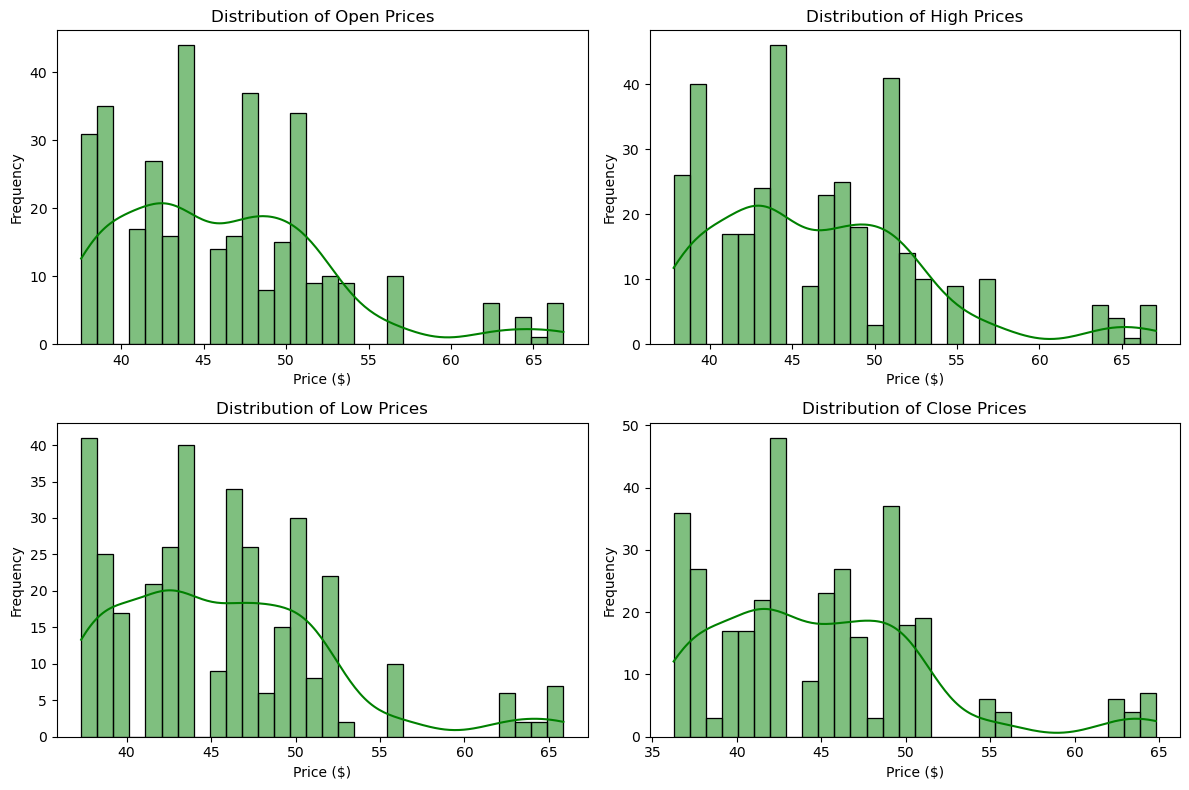

In [11]:
# Plotting histograms for stock price variables

price_columns = ['Open', 'High', 'Low', 'Close']

plt.figure(figsize = (12, 8))
for i, column in enumerate(price_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(stock_news[column], kde = True, bins = 30, color = 'green')
    plt.title(f'Distribution of {column} Prices')
    plt.xlabel('Price ($)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

> **Analysis of Distribution:** <br> The distributions for all four prices - Open, High, Low, Close are right-skewed with most of the data falling in the range of 40 to 50 dollars
>
> **Business Recommendation:** <br> There should be a focus to leaverage the 40 to 50 dollar price range for stock related campaigns as this range represents the most frequent activity. A higher return potential can be highlighted for investments beyond 55 dollars along with the risk factors as this has sparse occurence

<u>**Distribution of Sentiment Labels**

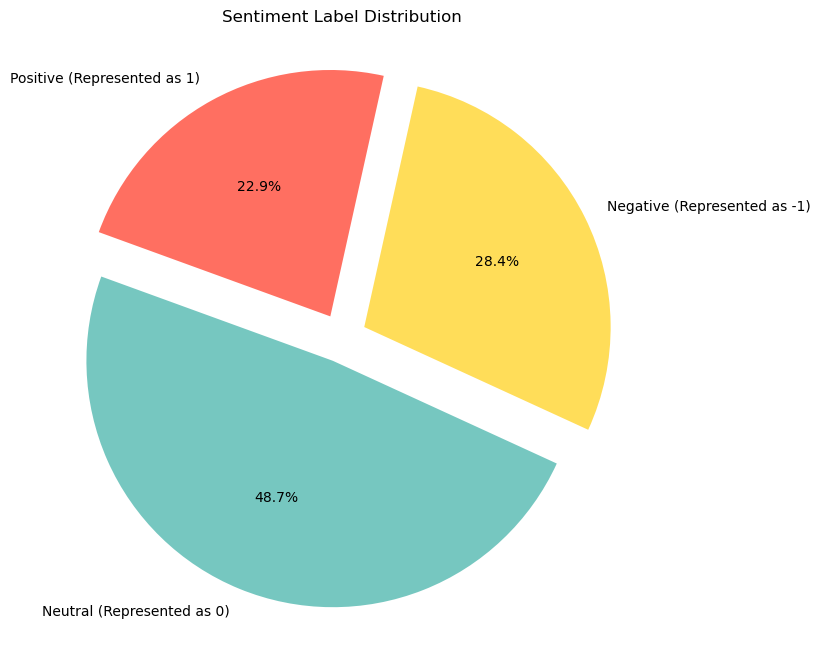

In [12]:
# Pie-Chart for sentiment labels

# Preparing data for the pie chart
label_counts = stock_news['Label'].value_counts()
labels = ["Neutral (Represented as 0)", "Negative (Represented as -1)", "Positive (Represented as 1)"]
colors = ['#76c7c0', '#ffdd59', '#ff6f61']

# Creating the pie chart
plt.figure(figsize = (8, 8))
plt.pie(label_counts, labels = labels, autopct = '%1.1f%%', startangle = 160, colors = colors, explode = (0.1, 0.1, 0.1))
plt.title("Sentiment Label Distribution")
plt.show()

> * From the pie-chart distribution, we can see that there is an imbalanced distribution for the 3 classes - 0 (Neutral), -1 (Negative) and 1 (Positive) indicating that there might be a need to do balancing if there is an ask
> * While the Neutral Sentiment label take around half of the distribution with Positive and Negative Sentiment Labels summing up to the other half, it is recommended to have this consideration shile doing the train test split
> * There should be a focus on identifying positive and negative events since they are crucial for actionable insights as dependency on neutral outcomes may lead to missed opportunities or risks

<u>**Distribution of Volume of Shares Traded**

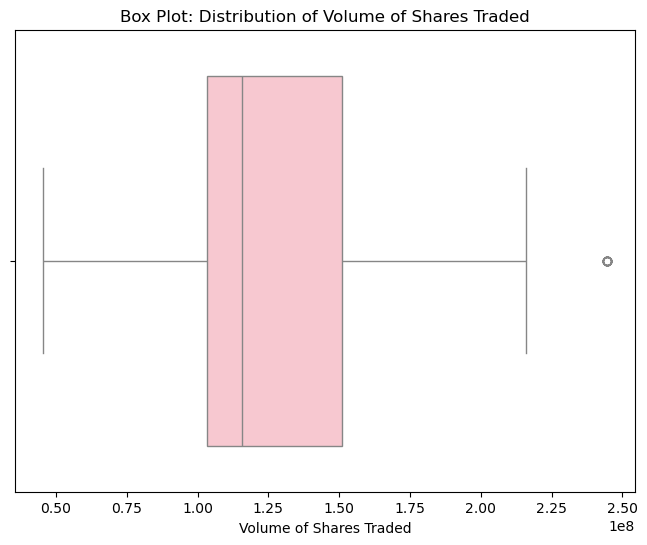

In [13]:
# Box plot for Volume of Shares Traded
plt.figure(figsize = (8, 6))
sns.boxplot(x = stock_news['Volume'], color = "pink")
plt.title("Box Plot: Distribution of Volume of Shares Traded")
plt.xlabel("Volume of Shares Traded")
plt.show()

> From the above box plot distribution, we see that most of our data is concentrated within the interquartile range (IQR), and we do not have much outliers
> * The data seems to be right skewed with median closer to the lower bound of the box
> * There is a single outlier on the higher end, representing an exceptionally large volume of shares traded compared to the rest of the dataset
> * This could be a unique trading event or an anomaly observed in trading which could be worth investigating further

### Bivariate Analysis

<u>**Correlation Heatmap for numerical Values**

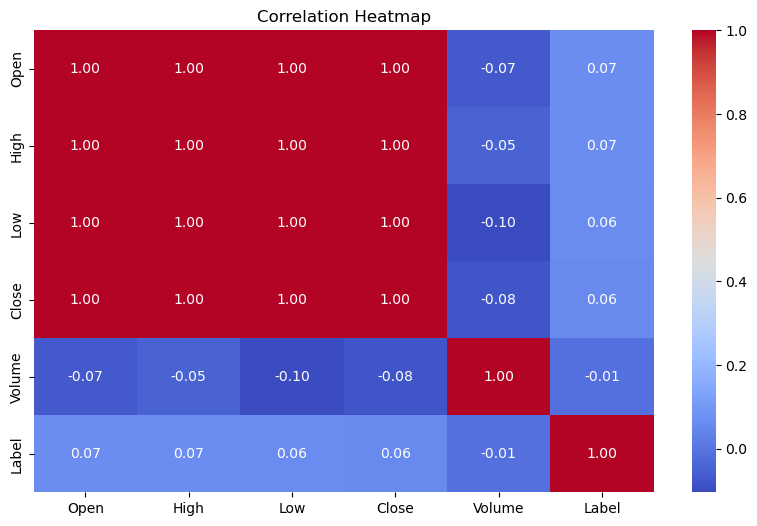

In [14]:
plt.figure(figsize = (10, 6))
correlation_matrix = stock_news[['Open', 'High', 'Low', 'Close', 'Volume', 'Label']].corr()

sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")

plt.title("Correlation Heatmap")
plt.show()

> From above heatmap, we oberver below points:
> * **Close**, **High**, **Low**, and **Open** prices are highly positively correlated. This is because these prices for a stock on a given day come from the same price movements and are naturally tied to each other
> * **Volume** shows a weaker correlation with the all the prices, indicating that trading volume does not directly predict stock prices in our given dataset
> * Like Volume, **Label** is also observed to have a low correlation with other features. This suggests that we need to explore more on its direct impact on movement of stock prices

<u>**Distribution for Sentiment Label vs Stock Prices**

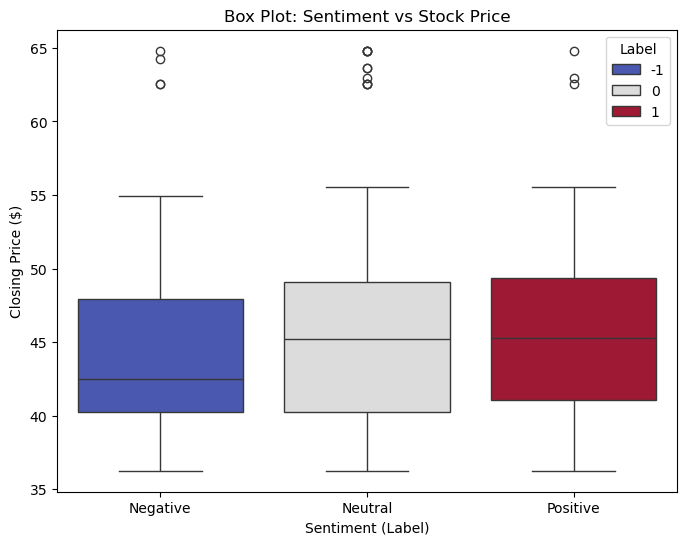

In [15]:
# Box plot for sentiment and closing price

plt.figure(figsize = (8, 6))
sns.boxplot(x = stock_news['Label'], y = stock_news['Close'], palette = "coolwarm", hue = stock_news['Label'])
plt.title("Box Plot: Sentiment vs Stock Price")
plt.xlabel("Sentiment (Label)")
plt.ylabel("Closing Price ($)")
plt.xticks(ticks = [0, 1, 2], labels = ["Negative", "Neutral", "Positive"])
plt.show()

> As we have seeing a perfect correlation of 1 between all the prices, representing only 1 of them w.r.t. the Label should provide the explanation of other 3 as well. Here we are considering Closing Prices with the Label to check the distribution of Prices with Label.
>  * The interquartile range (IQR) for all sentiment categories is similar, but Neutral has a slightly broader spread when compared to the Positive and Negative sentiment. This might be because Neutral sentiment doesn't have a significant impact on the market wheras the Positive and Negative do impact the investor decisions
>  * All categories show outliers, with Neutral having more instances which indicates that, despite being labeled as Newural News, certain events triggered unexpected reactions in the stock market
>  * Neutral sentiment label also has a slightly higher median closing price compared to Positive and Negative which suggests that this label reflects stability in the stock market
>  * We also see that the box plots for all three sentiment categories (Negative, Neutral, and Positive) appear relatively symmetric, without any significant skewness. This suggests that only checking sentiment label may not be the sole factor impacting the price movement across market
> 
> Overall, to enhance the stock market analysis, investors should also consider other key market factors like trading volumes, price fluctuations, and external economic factors. This can be clubbed with a system to summarize weekly news articles, highlighting top positive and negative events alongside stock price changes, to provide actionable insights.

### Multivariate Analysis

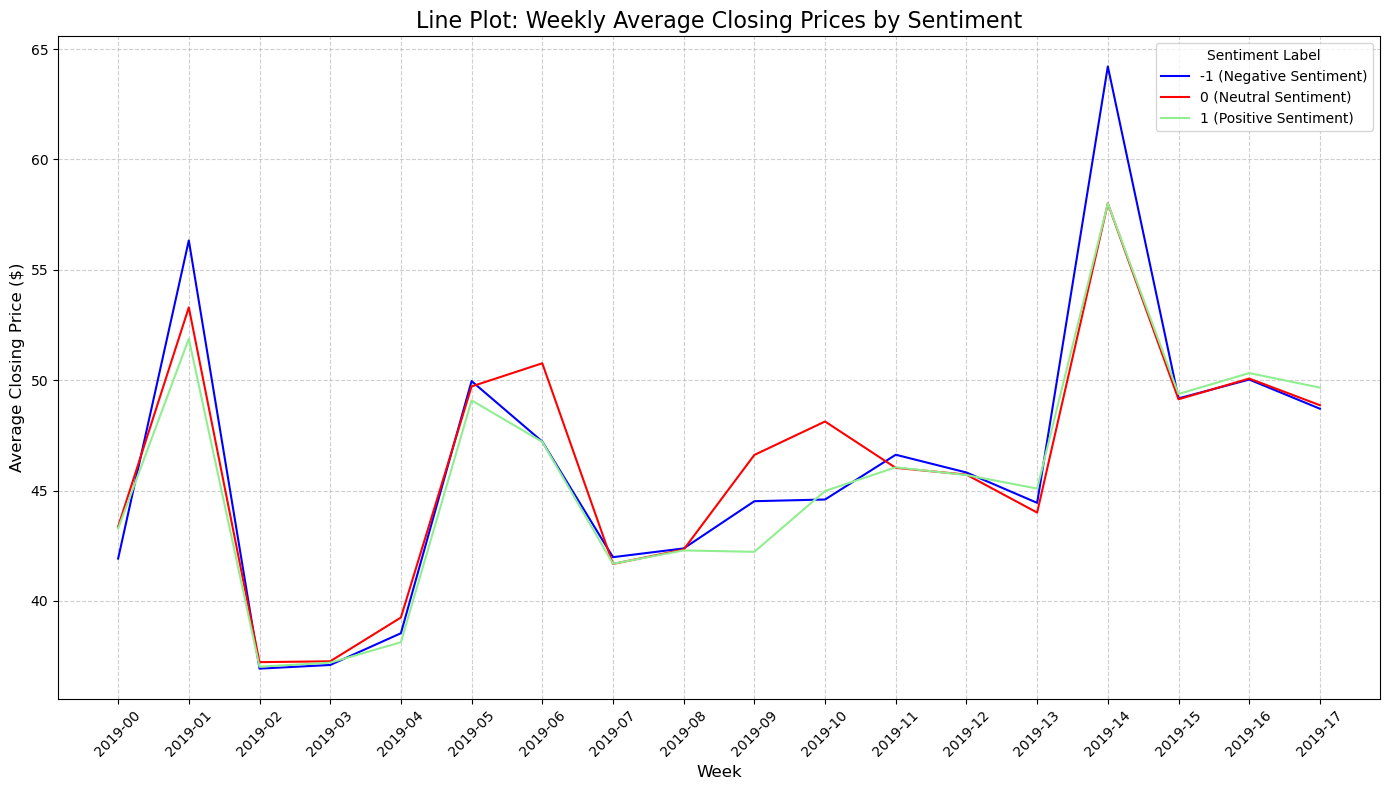

In [16]:
# To group data by week and sentiment label to calculate the mean
stock_news['Week'] = pd.to_datetime(stock_news['Date'], errors = 'coerce').dt.strftime('%Y-%U')
avg_weekly_prices = stock_news.groupby(['Week', 'Label'])[['Close']].mean().reset_index()

# To collect and pivot the data for plotting
line_plot_data = avg_weekly_prices.pivot(index = 'Week', columns = 'Label', values = 'Close')

# Plotting the data
plt.figure(figsize = (14, 8))

colors = ['blue', 'red', 'lightgreen']
labels = ['Negative', 'Neutral', 'Positive']

for idx, sentiment in enumerate(line_plot_data.columns):
    plt.plot(line_plot_data.index, line_plot_data[sentiment], label=f"{sentiment} ({labels[idx]} Sentiment)", color=colors[idx])

plt.title("Line Plot: Weekly Average Closing Prices by Sentiment", fontsize = 16)
plt.xlabel("Week", fontsize = 12)
plt.ylabel("Average Closing Price ($)", fontsize = 12)
plt.legend(title = "Sentiment Label")
plt.xticks(rotation = 45)
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.show()

Plotted a weekly average closing prices grouped by sentiment labels (-1, 0, and 1) above
 * Notable peaks are visible in weeks 1 and 14 which suggests significant market events or changes during those weeks for all the Sentiment Labels
 * Negative Sentiment seems to show similar trends to other sentiment labels but consistently leads compared to the other sentiment groups
 * Positive Sentiment seems to consistently align with or lags behind Neutral Sentiment. This may imply that the Positive Sentiment does not always lead to significantly higher average prices
 * The sharp peaks and troughs can be strong and week market trends which could be crucial deciding factors in investments during those weekly cycles and could indicate postive and negative market reactions
 * The minimal divergence among sentiment categories across the line graph suggests that while label sentiment distribution is a useful metric, it may not be the sole driver of stock prices
 * Investors could try investigating the events that caused the major spikes or dips in prices (e.g., weeks 2019-01 and 2019-13) which could help identify patterns in how the market reacts to News

In [17]:
stock_news.head()

,Date,News,Open,High,Low,Close,Volume,Label,Week
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1,2019-00
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1,2019-00
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1,2019-00
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1,2019-00
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1,2019-00


In [18]:
# Deleting the newly created 'Week' columns for data analysis
stock_news = stock_news.drop(columns = ['Week'])
stock_news.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


### Use appropriate visualizations to identify the patterns and insights

> We have created visualizations for each of the plot distributions and analysed them.
> The data distribution is thoroughly analysed and the required insights are shared along with each distribution in detail

### Key meaningful observations on individual variables and the relationship between variables

* **Observation on Individual Variables**
    - <u>Date</u> represents the trading day for the associated stock prices and news sentiment. Weekly and time-based trends can be derived from this variable
        <br>
    - <u>News</u> captures the news text that influences the sentiment (Label) and potentially impacts stock prices
        <br>
    - <u>Open, Close, High, Low</u> are the numerical features representing stock prices at different points of the trading day. Distributions are right-skewed and prices are closely related and exhibit strong positive correlations, indicating they follow the same daily trends
        <br>
    - <u>Volume</u> crepresents the number of shares traded during the day. The distribution is slightly right-skewed, with a few outliers indicating unusually high trading activity
        <br>
    - <u>Label</u> represents the sentiment of the news
        * **-1 (Negative)** reflects bad news likely to lower stock prices.
        * **0 (Neutral)** reflects neutral news with minimal market impact.
        * **1 (Positive)** reflects good news likely to increase stock prices
        * The distribution is imbalanced, with Neutral (~50%) dominating the dataset, while Positive and Negative are evenly split in the remaining 50%
        <br><br>
* **Relationships Between Variables**
    - <u>Label vs. Open, Close, High, Low</u>: 
        * Positive sentiment tends to align with slight increases in stock prices, while Negative sentiment aligns with decreases in stock prices
        * Neutral sentiment often corresponds to stable stock prices
        * All sentiment categories show a similar interquartile range (IQR), but Neutral has a slightly broader spread of outliers
        <br>
    - <u>Volume vs. Sentiment (Label)</u>: 
        * Positive sentiment shows moderate increases in trading volume
        * Higher trading volumes are sometimes associated with Negative sentiment. This might be because investors tend to sell stocks in reaction to bad news
    - <u>Correlation Among Numerical Variables</u>: 
        * Open, Close, High, and Low are tightly correlated (correlation coefficients near 1), indicating they all follow similar trends on the same day
        * Volume and Label shows a weak correlation with stock prices
        * Negative sentiment appears to lead market reactions more consistently compared to Positive sentiment
        <br><br>
* Overall, Sentiment alone isn’t a strong predictor but acts as a meaningful secondary signal when combined with other variables like trading volume and external market conditions. Also, stock prices move together due to shared influences, making it sufficient to analyze one of these further

***

# <u>Data Preprocessing</u>

> Under this, we can do some work on our already provided data to make it efficient for our further use. For this we can perform the following actions on the stock_news dataframe:
> * Restrict float values to 3 decimal places
> * Remove extra white spaces from the News text
> * Lowercase all News text to maintain uniformity
> * Remove any special characters from the text
> * Remove stopwords from News to reduce noise
> * Stemming to remove suffixes and ensure similar words are treated as same

> For this, let's have a new column created named 'Cleaned_News' for now. This column will have the cleaned and processed text from the News column

<u>**Restrict float values to 3 decimal places**

In [19]:
float_columns = ['Open', 'Close', 'Low', 'High']  # Replace with actual float column names
stock_news[float_columns] = stock_news[float_columns].round(3)

stock_news.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.245,41.482,40.247,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.245,41.482,40.247,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.245,41.482,40.247,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.74,42.245,41.482,40.247,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.245,41.482,40.247,130672400,-1


<u>**Remove Extra White Spaces**

In [20]:
stock_news['Cleaned_News'] = stock_news['News'].str.strip()

# Calculating total extra white spaces removed
total_whitespace_removed = (stock_news['News'].str.len() - stock_news['Cleaned_News'].str.len()).sum()

print(f"\nTotal extra white spaces removed: {total_whitespace_removed}")

stock_news.head()


Total extra white spaces removed: 336


,Date,News,Open,High,Low,Close,Volume,Label,Cleaned_News
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.245,41.482,40.247,130672400,-1,The tech sector experienced a significant decl...
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.245,41.482,40.247,130672400,-1,Apple lowered its fiscal Q1 revenue guidance t...
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.245,41.482,40.247,130672400,-1,Apple cut its fiscal first quarter revenue for...
3,2019-01-02,This news article reports that yields on long...,41.74,42.245,41.482,40.247,130672400,-1,This news article reports that yields on long-...
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.245,41.482,40.247,130672400,-1,Apple's revenue warning led to a decline in US...


<u>**Lowercase all News text**

In [21]:
stock_news['Cleaned_News'] = stock_news['Cleaned_News'].str.lower()

stock_news.head()

,Date,News,Open,High,Low,Close,Volume,Label,Cleaned_News
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.245,41.482,40.247,130672400,-1,the tech sector experienced a significant decl...
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.245,41.482,40.247,130672400,-1,apple lowered its fiscal q1 revenue guidance t...
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.245,41.482,40.247,130672400,-1,apple cut its fiscal first quarter revenue for...
3,2019-01-02,This news article reports that yields on long...,41.74,42.245,41.482,40.247,130672400,-1,this news article reports that yields on long-...
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.245,41.482,40.247,130672400,-1,apple's revenue warning led to a decline in us...


<u>**Remove Special Characters**

In [22]:
length_with_special_characters = stock_news['Cleaned_News'].str.len().sum()

# remove special characters
stock_news['Cleaned_News'] = stock_news['Cleaned_News'].str.replace("[^A-Za-z0-9']+", " ", regex = True)

# Removing apostrophes
stock_news['Cleaned_News'] = stock_news['Cleaned_News'].str.replace("'", "", regex = False)

length_without_special_characters = stock_news['Cleaned_News'].str.len().sum()

special_characters_removed = length_with_special_characters - length_without_special_characters

print(f"\nTotal number of special characters removed: {special_characters_removed}")

stock_news.head()


Total number of special characters removed: 2250


,Date,News,Open,High,Low,Close,Volume,Label,Cleaned_News
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.245,41.482,40.247,130672400,-1,the tech sector experienced a significant decl...
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.245,41.482,40.247,130672400,-1,apple lowered its fiscal q1 revenue guidance t...
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.245,41.482,40.247,130672400,-1,apple cut its fiscal first quarter revenue for...
3,2019-01-02,This news article reports that yields on long...,41.74,42.245,41.482,40.247,130672400,-1,this news article reports that yields on long ...
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.245,41.482,40.247,130672400,-1,apples revenue warning led to a decline in usd...


<u>**Remove Stopwords**

In [23]:
# Counting the number of words before removing stopwords
words_with_stopwords = stock_news['Cleaned_News'].apply(lambda text: len(text.split())).sum()

# Splitting the News text into separate words and removing English language stopwords
stock_news['Cleaned_News'] = stock_news['Cleaned_News'].apply(lambda text: 
                                                              ' '.join([word for word in text.split() 
                                                                        if word not in stopwords.words('english')]))

# Counting the number of words after removing stopwords
words_without_stopwords = stock_news['Cleaned_News'].apply(lambda text: len(text.split())).sum()

stopwords_removed = words_with_stopwords - words_without_stopwords

print(f"\nTotal number of stopwords removed: {stopwords_removed}")

stock_news.head()


Total number of stopwords removed: 5428


,Date,News,Open,High,Low,Close,Volume,Label,Cleaned_News
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.245,41.482,40.247,130672400,-1,tech sector experienced significant decline af...
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.245,41.482,40.247,130672400,-1,apple lowered fiscal q1 revenue guidance 84 bi...
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.245,41.482,40.247,130672400,-1,apple cut fiscal first quarter revenue forecas...
3,2019-01-02,This news article reports that yields on long...,41.74,42.245,41.482,40.247,130672400,-1,news article reports yields long dated u treas...
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.245,41.482,40.247,130672400,-1,apples revenue warning led decline usd jpy pai...


<u>**Stemming**

> We'll be applying Stemming now which will shorten the words to their root form by removing suffixes. It will reduce the words to a common base form, which will help reduce the dimensionality in further NLP tasks

In [24]:
# Loading the Porter Stemmer
ps = PorterStemmer()
ps

<PorterStemmer>

In [25]:
characters_before_stemming = stock_news['Cleaned_News'].str.len().sum()

# Applying Stemming
stock_news['Cleaned_News'] = stock_news['Cleaned_News'].apply(lambda text:
                                                              ' '.join([ps.stem(word) 
                                                                        for word in text.split()]))

characters_after_stemming = stock_news['Cleaned_News'].str.len().sum()

characters_removed = characters_before_stemming - characters_after_stemming

print(f"\nTotal number of characters removed while stemming: {characters_removed}")

stock_news.head()


Total number of characters removed while stemming: 11449


,Date,News,Open,High,Low,Close,Volume,Label,Cleaned_News
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.245,41.482,40.247,130672400,-1,tech sector experienc signific declin aftermar...
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.245,41.482,40.247,130672400,-1,appl lower fiscal q1 revenu guidanc 84 billion...
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.245,41.482,40.247,130672400,-1,appl cut fiscal first quarter revenu forecast ...
3,2019-01-02,This news article reports that yields on long...,41.74,42.245,41.482,40.247,130672400,-1,news articl report yield long date u treasuri ...
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.245,41.482,40.247,130672400,-1,appl revenu warn led declin usd jpi pair gain ...


> Now that we are done with the preprocessing of our data, let's move forward to splitting the taregt variable and separate the train, test and validation sets

### Split the Target Variable and Predictors

> We will be considering 'Label' as our target variable.
> <br> All other columns will act as predictors.

In [26]:
X = stock_news.drop(columns = ['Label'])  # Predictors (all columns except 'Label')
y = stock_news['Label']  # Target variable, 'Label'

### Split the Data into train, validation, and test sets

> To split our data in 3 sets - train, test and validation, we will folllow the below approach
> * We will be splitting our train and test sets in an 80-20 ratio, i.e., 80% split to train set and 20% split to test set
> * Next we will take our 80% split training set and will apply a train-test split on it again with a 75-25 ratio
>     - This will split the final train test to 75% of previous 80%, i.e., 60% of the total data
>     - The final validation set will be 25% of 80%, i.e., 20% of total data
> * We will also use **'stratify = y'** to ensure that all 3 sets reflect the class proportions same as in the original dataset and splitting is not random and the train-test split doesn't result in an uneven distribution of classes
> 
> The final split would be below:
| Dataset         | Percentage Split |
|-----------------|------------------|
| Train Set       | 60%              |
| Validation Set  | 20%              |
| Test Set        | 20%              |
| **Total**       | 100%             |

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, stratify = y_train, random_state = 42)

In [28]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

print(f"\nNumber of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of validation samples: {len(X_val)}")

# Printing the shapes of the train and test sets
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_val:", X_val.shape)
print("\nShape of y_train:", y_train.shape[0])
print("Shape of y_test:", y_test.shape[0])
print("Shape of y_val:", y_val.shape[0])


Number of training samples: 209
Number of testing samples: 70
Number of validation samples: 70

Shape of X_train: (209, 8)
Shape of X_test: (70, 8)
Shape of X_val: (70, 8)

Shape of y_train: 209
Shape of y_test: 70
Shape of y_val: 70


***

# <u>Word Embeddings</u>

> As per the ask, word embeddings will be done using below methods:
> * Word2Vec
> * GloVe
> * Sentence Transformer

### Using Word2Vec

In [29]:
# Creating a list of all words in our data
list_of_words = [item.split(" ") for item in stock_news['Cleaned_News'].values]

flat_list_of_words = [word for sublist in list_of_words for word in sublist]

print("\n Number of words in our data - ", len(flat_list_of_words))


 Number of words in our data -  11907


In [30]:
# Creating an instance of Word2Vec

word2vec_model = Word2Vec(list_of_words,
                          vector_size = 200,
                          min_count = 1,
                          window = 5,
                          workers = 6)
word2vec_model

> Here, our code is initializing and training our Word2Vec model using the Gensim library
> * **vector_size** specifies the dimensionality of the word vectors (i.e., the size of the embedding for each word). higher values might indicate overfitting so kept it as 200
> * **min_count** indicates the minimum frequency of a word to be included in the vocabulary. We've kep it as 1 so all words are included and none is left unaddressed
> * **window** determines how many words before and after the target word are considered for training. We can choose it based on our need
> * **workers** is the number of parallel worker threads, i.e., CPU cores, used for training the model. Here we are using 6 CPU threads for training our model

In [31]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(word2vec_model.wv.key_to_index)))

Length of the vocabulary is 2584


In [32]:
# Checking the word embedding of a random word
random_word = 'quarter'
word2vec_model.wv[random_word]

array([-4.74225555e-04, -5.01796370e-03, -2.42728740e-03,  1.01196254e-02,
        9.25968494e-03, -1.21490881e-02, -2.70155421e-03,  1.62857957e-02,
       -8.59179068e-03,  3.74760735e-03, -7.40333926e-03, -1.28789274e-02,
        9.12690710e-04,  7.86085427e-03,  4.10042237e-04, -7.56595749e-03,
       -3.09519842e-03,  2.27486179e-03,  5.98286977e-04, -1.00562638e-02,
        8.13674275e-03, -8.61698110e-03, -6.89120172e-03,  8.67933792e-04,
        4.86380653e-03, -4.04673722e-03, -6.07726164e-03, -9.04713944e-03,
       -1.38164703e-02,  3.60319670e-03,  3.51112103e-03,  7.01084221e-03,
        8.34211591e-04, -9.29009693e-04, -2.37606652e-03,  6.70197047e-03,
        2.45924876e-03, -4.80970414e-03, -5.13518928e-03, -1.18435621e-02,
       -7.88632873e-03,  8.92203941e-04,  4.31631878e-03,  3.76525708e-03,
        9.74482019e-03, -1.81862048e-03,  5.14216837e-04, -5.17160399e-03,
        1.22190511e-03,  8.09669029e-03,  5.07844146e-03, -6.23410195e-03,
       -9.98243922e-04, -

In [33]:
# checking words similar to a random word. 'market' in below case

similar_words = word2vec_model.wv.most_similar(random_word, topn = 5)
print(f"\nWords similar to '{random_word}':", similar_words)


Words similar to 'quarter': [('appl', 0.8835233449935913), ('trade', 0.8699706196784973), ('compani', 0.8630620837211609), ('market', 0.8629351854324341), ('stock', 0.8620415925979614)]


> Now that we are done with embedding using Word2Vec, we will now proceed with summarizing each text/sentence  into a single average vector representation instead of having different vectors for each word of the sentence. 
>  
> * With this, each sentence text will now be represented by a single vector stored in a new column, named **'Word2Vec_Embedding'**
> * This will help us reduce the complexity of different vectors into a compact single vector format that can be easily used further

In [34]:
# Function to aggregate embeddings
def get_avg_word2vec(text_in_list_of_words, model, vector_size):
    """
    Returns the average Word2Vec vector for a text
    text_in_list_of_words: This is the individual text which needs to be averaged to a single vector
    model: This is the initialized and trained Word2Vec model
    vector_size: The size of final averaged vector
    """
    valid_words = [model.wv[word] for word in text_in_list_of_words if word in model.wv]
    if len(valid_words) > 0:
        return np.mean(valid_words, axis = 0)
    else:
        return np.zeros(vector_size)

In [35]:
# Creating embeddings for the full dataset and storing in a new column, 'Word2Vec_Embedding'
text_to_words_list = stock_news['Cleaned_News'].apply(lambda text: text.split())

stock_news['Word2Vec_Embedding'] = text_to_words_list.apply(lambda words_list: 
                                                            get_avg_word2vec(words_list, word2vec_model, 100))
stock_news.head()

,Date,News,Open,High,Low,Close,Volume,Label,Cleaned_News,Word2Vec_Embedding
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.245,41.482,40.247,130672400,-1,tech sector experienc signific declin aftermar...,"[-0.00011684425, -0.00060144195, 0.0006461383,..."
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.245,41.482,40.247,130672400,-1,appl lower fiscal q1 revenu guidanc 84 billion...,"[5.8733815e-05, 0.00027820357, 0.0015482046, 0..."
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.245,41.482,40.247,130672400,-1,appl cut fiscal first quarter revenu forecast ...,"[-0.0010485507, -0.00080583367, 0.0011581908, ..."
3,2019-01-02,This news article reports that yields on long...,41.74,42.245,41.482,40.247,130672400,-1,news articl report yield long date u treasuri ...,"[-7.2100745e-05, 0.0007391105, 0.0013536963, 0..."
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.245,41.482,40.247,130672400,-1,appl revenu warn led declin usd jpi pair gain ...,"[0.00026393068, -0.00030037403, 0.0010759784, ..."


### Using GloVe

In [36]:
glove_file = "C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 10 -  Natural Language Processing (Week 38 to Week 42)/Project/glove.6B.100d.txt.word2vec"

#Loading the GloVe Model
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary = False)

glove_model

> Here, we are loading pre-trained GloVe word embeddings into a format that can be used with the Gensim library.
> * Since, the file says 6B.100d, it means our pre-trained model was trained on a corpus of 6 billion tokens (words) and each word is 100-dimensional
> * We have kept **'binary = false'** as we want the file in a plain text format and not a binary format for easier future use
> * **glove_model** will now have the pretrained glove vectors

In [37]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [38]:
# Checking the word embedding of a random word
random_word = "stock"
glove_model[random_word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

> Now, that our model is created, we will now be summarizing each of the News text (Cleaned_News) to a single vector of 100 dimensions
> * The function will find the embeddings for the valid words and retrieve it. We will use the previous method, **get_avg_embedding** for this
> * It will then average the values of each word in the sentence and result in an averaged vector
> * This will be stored in **'GloVe_Embedding'** column

In [39]:
# Function to aggregate embeddings
def get_avg_glove(text_in_list_of_words, model, vector_size):
    """
    Returns the average Word2Vec vector for a text
    text_in_list_of_words: This is the individual text which needs to be averaged to a single vector
    model: This is the initialized and trained GloVe model
    vector_size: The size of final averaged vector
    """
    valid_words = [model[word] for word in text_in_list_of_words if word in model]
    if len(valid_words) > 0:
        return np.mean(valid_words, axis = 0)
    else:
        return np.zeros(vector_size)

In [40]:
# Creating embeddings for the full dataset and storing in a new column, 'GloVe_Embedding'
text_to_words_list = stock_news['Cleaned_News'].apply(lambda text: text.split())

stock_news['GloVe_Embedding'] = text_to_words_list.apply(lambda words_list: 
                                                         get_avg_glove(words_list, glove_model, 100))
stock_news.head()

,Date,News,Open,High,Low,Close,Volume,Label,Cleaned_News,Word2Vec_Embedding,GloVe_Embedding
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.245,41.482,40.247,130672400,-1,tech sector experienc signific declin aftermar...,"[-0.00011684425, -0.00060144195, 0.0006461383,...","[0.021671351, 0.09678528, -0.047464475, -0.066..."
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.245,41.482,40.247,130672400,-1,appl lower fiscal q1 revenu guidanc 84 billion...,"[5.8733815e-05, 0.00027820357, 0.0015482046, 0...","[0.171825, 0.34135053, 0.23464985, -0.04205366..."
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.245,41.482,40.247,130672400,-1,appl cut fiscal first quarter revenu forecast ...,"[-0.0010485507, -0.00080583367, 0.0011581908, ...","[0.010512237, 0.2703414, 0.30148184, -0.087113..."
3,2019-01-02,This news article reports that yields on long...,41.74,42.245,41.482,40.247,130672400,-1,news articl report yield long date u treasuri ...,"[-7.2100745e-05, 0.0007391105, 0.0013536963, 0...","[-0.14740694, 0.22696981, 0.37715748, 0.184659..."
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.245,41.482,40.247,130672400,-1,appl revenu warn led declin usd jpi pair gain ...,"[0.00026393068, -0.00030037403, 0.0010759784, ...","[0.04079848, 0.19831154, 0.071460426, 0.037331..."


### Using Sentence Transformer

In [41]:
# Defining the model
sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

sentence_transformer_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

> We've loaded the **all-MiniLM-L6-v2 model** here. It is a compact and efficient model that generates high-quality sentence embeddings
> * **MiniLM:** A lightweight model based on Transformers
> * **L6:** It has 6 layers, making it computationally efficient
> * **v2:** A fine-tuned version for better accuracy
>
> By default, the pre-trained all-MiniLM-L6-v2 model is a 768-dimensional vector, meaning it has 768 numerical values in 1 vector

In [42]:
# Getting embedding for a single News Text
random_news = stock_news['Cleaned_News'].iloc[0]
embedding = sentence_transformer_model.encode(random_news)
print("\n Cleaned News Article Example - ", random_news)
print("\nSentence Transformer Embedding for first news article:\n", embedding)


 Cleaned News Article Example -  tech sector experienc signific declin aftermarket follow appl q1 revenu warn notabl supplier includ skywork broadcom lumentum qorvo tsmc saw stock drop respons appl downward revis revenu expect quarter previous announc januari

Sentence Transformer Embedding for first news article:
 [-4.35230136e-02 -3.29503790e-02  1.18766623e-02 -2.81184074e-02
 -4.92299423e-02 -3.22515331e-02  6.49221614e-02  8.59605297e-02
 -5.15835965e-03 -7.01684318e-03  6.41608983e-02  6.85867388e-03
  5.48728881e-03 -1.17762713e-02 -2.30298191e-02 -6.20182119e-02
  3.91355995e-03 -3.52360904e-02 -8.98560286e-02 -6.32311031e-02
 -4.57198396e-02 -7.06845447e-02 -5.99571913e-02  2.73745898e-02
 -1.07715428e-02 -3.64985690e-02  1.46401329e-02  7.55968690e-02
  4.79061119e-02 -1.22141287e-01 -5.15050143e-02  1.34289786e-01
  4.91506308e-02  3.63531262e-02  1.16165532e-02  1.05563272e-02
 -6.83339895e-04 -4.49276082e-02  4.31670956e-02 -1.22120008e-02
 -5.07503077e-02 -8.38373527e-02

> Now, we will proceed with generating vector embeddings for all the News texts in our dataset.
>
> Using sentence transformer model will result in a 768-dimensional embedding that captures the specific sentence's meaning. this will be stored in a new column, **'SentenceTransformer_Embedding'**

In [43]:
# Generating averaged embeddings for each News Text
start_time = time.time()
stock_news['SentenceTransformer_Embedding'] = stock_news['Cleaned_News'].apply(lambda text: 
                                                                               sentence_transformer_model.encode(text))
end_time = time.time()

total_time = end_time - start_time

if(total_time < 60):
    print(f"\n Total time taken for generating averaged embeddings using Sentence Transformer - {total_time:.2f} seconds")
else:
    print(f"\n Total time taken for generating averaged embeddings using Sentence Transformer - ",
          int(total_time / 60), "minute(s)", int(total_time % 60), "second(s)")

stock_news.head()


 Total time taken for generating averaged embeddings using Sentence Transformer - 21.17 seconds


,Date,News,Open,High,Low,Close,Volume,Label,Cleaned_News,Word2Vec_Embedding,GloVe_Embedding,SentenceTransformer_Embedding
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.245,41.482,40.247,130672400,-1,tech sector experienc signific declin aftermar...,"[-0.00011684425, -0.00060144195, 0.0006461383,...","[0.021671351, 0.09678528, -0.047464475, -0.066...","[-0.043523014, -0.03295038, 0.011876662, -0.02..."
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.245,41.482,40.247,130672400,-1,appl lower fiscal q1 revenu guidanc 84 billion...,"[5.8733815e-05, 0.00027820357, 0.0015482046, 0...","[0.171825, 0.34135053, 0.23464985, -0.04205366...","[-0.04631528, -0.010828302, 0.026855234, -0.01..."
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.245,41.482,40.247,130672400,-1,appl cut fiscal first quarter revenu forecast ...,"[-0.0010485507, -0.00080583367, 0.0011581908, ...","[0.010512237, 0.2703414, 0.30148184, -0.087113...","[-0.026370611, -0.011946567, 0.08637547, 0.021..."
3,2019-01-02,This news article reports that yields on long...,41.74,42.245,41.482,40.247,130672400,-1,news articl report yield long date u treasuri ...,"[-7.2100745e-05, 0.0007391105, 0.0013536963, 0...","[-0.14740694, 0.22696981, 0.37715748, 0.184659...","[-0.02124004, 0.036464244, 0.00796498, 0.03656..."
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.245,41.482,40.247,130672400,-1,appl revenu warn led declin usd jpi pair gain ...,"[0.00026393068, -0.00030037403, 0.0010759784, ...","[0.04079848, 0.19831154, 0.071460426, 0.037331...","[-0.062147245, 0.008859493, -0.046555568, 0.03..."


***

# <u>Sentiment Analysis</u>

In [44]:
stock_news['Label'].value_counts()

Label
 0    170
-1     99
 1     80
Name: count, dtype: int64

### Comment on which metric to use and why

> As we see above, the class distribution of the Label column (target variable) is imbalanced with around half the distribution inclined to the Neutral, i.e., the 0 class and the other half being divided between Positive (1) and Negative (-1) classes.
>
> Seeing this, we might not have Accuracy as a good choice of metric for evaluating the model because it may be misleading in imbalanced datasets like ours as it might fail to identify minority classes
>
> In our case, 
> * Labels 1 (Positive) and -1 (Negative) are minority classes but are crucial for driving investment decisions
> * Misclassifying positive or negative sentiment as Neutral (0) can lead to missed opportunities or wrong investments
> * Similarly, a high false positive rate for labels 1 or -1 could lead to unnecessary risk
>
> Here, it’s critical to correctly identify positive or negative sentiment to avoid missing key opportunities or risks. **Recall** can be helpful in such case. Also, using **Precision** also can ensure that the identified positive or negative sentiment is trustworthy. 
>
> Thus, using a combination of both Recall and Precision can be beneficial in our case and hence, using **F1-Score** as the evaluation metric will be a good choice as it will povide a balanced perspective on the performance across all classes without favoring the majority class (0). It will highlight both precision and recall for positive and negative sentiments considering Recall and Precision in equal weightage and will be effective for our stock price predictions

### Build a ML Model with the 3 Embedding Techniques

> As the choice of choosing the Machine Learning Model depends on us, We will see what all factors from our problem definition help us identify our ML model.
> * **Nature of Data:** 
>     - We have multiple types of data - Sentiment labels (-1, 0, 1) which indicate the market mood, Numerical Stock values (Open, Close, High, Low) which represent the market trend and Trade Volume which tells about the trading activity
>     - All these features are tabular and sequentially correlated. And tree-based models such as Random Forest and GradientBoosting can be effective choice here
> * **Data Size and Complexity:** 
>     - We have a smaller dataset of approximately 350 records and 8 columns including the target variable. 
>     - Complex Deep learning models can be computationally expensive and result in overfitting when not provided with appropriate dataset. Thus, models like Random Forest can perform well here
> * **Scalability and Future Deployment:**
>     - Since we are dealing with stock related data, it is important to have continuous live data feeds. Complex models can be computationally expensive and increase deployment cost
>     - Low latency models such as Boosting or Random Forest can be effective here instead of going with deep Neural Netwoks for effectiveness and fast training and inference making them ideal for our case as it also provides consistent performance across
> * **Stock Price Movements:**
>     - Since our task is to predict stock price movements based on sentiment, there is a mix of both regression (for price prediction) and classification (for sentiment analysis)
>     - Random Forest can handle both tasks effectively by building multiple decision trees and averaging their outputs, ensuring high accuracy and robustness
  
> Overall, based on the points above, we can clearly say that we will be using **Random Forest** as our ML model here.
>  * It captures non-linear patterns and handles complex data effectively
>  * It works well with high-dimensional tabular data
>  * By using class weight, it can address challenges in imbalanced datasets
>  * It handles noisy and missing data efficiently
>  * It is computationally efficient and scalable for our problem case
>
> Overall, **Random Forest** offers a balance of efficiency, and scalability, making it the ideal choice for predicting stock price movements based on sentiment analysis

<u>**Splitting the Target Variable and Predictors Again**

In [45]:
# Creating embeddings as NumPy arrays
X_word2vec = np.stack(stock_news['Word2Vec_Embedding'].values)
X_glove = np.stack(stock_news['GloVe_Embedding'].values)
X_sentence_transformer = np.stack(stock_news['SentenceTransformer_Embedding'].values)
y = stock_news['Label'].values

# Spliting train, test and validation sets
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    range(len(y)), y, test_size = 0.2, stratify = y, random_state = 42)

X_train_idx, X_val_idx, y_train, y_val = train_test_split(
    X_train_idx, y_train, test_size = 0.25, stratify = y_train, random_state = 42)

# Applying the same split indices to all embeddings
X_train_word2vec = X_word2vec[X_train_idx]
X_val_word2vec = X_word2vec[X_val_idx]
X_test_word2vec = X_word2vec[X_test_idx]

X_train_glove = X_glove[X_train_idx]
X_val_glove = X_glove[X_val_idx]
X_test_glove = X_glove[X_test_idx]

X_train_sentence_transformer = X_sentence_transformer[X_train_idx]
X_val_sentence_transformer = X_sentence_transformer[X_val_idx]
X_test_sentence_transformer = X_sentence_transformer[X_test_idx]

# Printing shapes to confirm - Creating a dictionary to hold the information
data = {
    "Embedding Type": ["Word2Vec", "GloVe", "Sentence Transformer"],
    "Training Samples": [
        len(X_train_word2vec),
        len(X_train_glove),
        len(X_train_sentence_transformer)
    ],
    "Validation Samples": [
        len(X_val_word2vec),
        len(X_val_glove),
        len(X_val_sentence_transformer)
    ],
    "Testing Samples": [
        len(X_test_word2vec),
        len(X_test_glove),
        len(X_test_sentence_transformer)
    ],
    "Training Shape": [
        str(X_train_word2vec.shape),
        str(X_train_glove.shape),
        str(X_train_sentence_transformer.shape)
    ],
    "Validation Shape": [
        str(X_val_word2vec.shape),
        str(X_val_glove.shape),
        str(X_val_sentence_transformer.shape)
    ],
    "Testing Shape": [
        str(X_test_word2vec.shape),
        str(X_test_glove.shape),
        str(X_test_sentence_transformer.shape)
    ],
}

df = pd.DataFrame(data)

print("\nTrain, Validation, and Test Set Summary:")
df.head()



Train, Validation, and Test Set Summary:


,Embedding Type,Training Samples,Validation Samples,Testing Samples,Training Shape,Validation Shape,Testing Shape
0,Word2Vec,209,70,70,"(209, 200)","(70, 200)","(70, 200)"
1,GloVe,209,70,70,"(209, 100)","(70, 100)","(70, 100)"
2,Sentence Transformer,209,70,70,"(209, 384)","(70, 384)","(70, 384)"


> We did a split again to ensure that the split aligns with the transformed data (embeddings) and their corresponding target labels. This will help prevent data leakage.

> Before starting with the next parts, let's create some functions so we don't have to repeat the lines of code

In [46]:
# Creating Confusion Matrix
def plot_confusion_matrix(conf_matrix_train, conf_matrix_test, conf_matrix_val):

    conf_matrices = [conf_matrix_train, conf_matrix_test, conf_matrix_val]
    titles = ['Confusion Matrix for Training Set', 'Confusion Matrix for Testing Set', 'Confusion Matrix for Validation Set']
    
    fig, axes = plt.subplots(1, 3, figsize = (15, 5))
    
    # Labels for the confusion matrix
    labels = ['Negative (-1)', 'Neutral (0)', 'Positive (1)']
    
    for i, (conf_matrix, title) in enumerate(zip(conf_matrices, titles)):
        sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', ax = axes[i], 
                    xticklabels = labels, yticklabels = labels, cbar = False)
        axes[i].set_title(title)
        axes[i].set_xlabel('Predicted Labels')
        axes[i].set_ylabel('Actual Labels')
        axes[i].tick_params(axis = 'x', labelsize = 12)
        axes[i].tick_params(axis = 'y', labelsize = 12)
    
    plt.subplots_adjust(wspace = 1.5) 
    plt.tight_layout()
    plt.show()

    print("Confusion Matrix for Final Training Set:\n", conf_matrix_train)
    print("Confusion Matrix for Final Testing Set:\n", conf_matrix_test)
    print("Confusion Matrix for Final Validation Set:\n", conf_matrix_val)

In [47]:
# Creating Evaluation Metrics for checking performance of the model
def evaluation_metrics(y_train, y_train_pred, y_test, y_test_pred, y_val, y_val_pred, conf_matrix_train, conf_matrix_test, conf_matrix_val):
    
    # Compute evaluation metrics for training set
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred, average = 'weighted')
    recall_train = recall_score(y_train, y_train_pred, average = 'weighted')
    f1_train = f1_score(y_train, y_train_pred, average = 'weighted')
    
    # Compute evaluation metrics for testing set
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred, average = 'weighted')
    recall_test = recall_score(y_test, y_test_pred, average = 'weighted')
    f1_test = f1_score(y_test, y_test_pred, average = 'weighted')
    
    # Compute evaluation metrics for validation set
    accuracy_val = accuracy_score(y_val, y_val_pred)
    precision_val = precision_score(y_val, y_val_pred, average = 'weighted')
    recall_val = recall_score(y_val, y_val_pred, average = 'weighted')
    f1_val = f1_score(y_val, y_val_pred, average = 'weighted')
    
    # Plot confusion matrix
    print("\nConfusion Matrices:")
    plot_confusion_matrix(conf_matrix_train, conf_matrix_test, conf_matrix_val)

In [48]:
def get_basic_model_metrics(model, X_train, y_train, X_test, y_test, X_val, y_val, embedding_name):
    """
    Performs a Model training along with printing the evaluation metrics
    
    Input Parameters:
    model: The model which we need to train
    X_train, y_train: Training sets of independent and target variables
    X_test, y_test: Testing sets of independent and target variables
    X_val, y_val: Validation sets of independent and target variables
    embedding_name: Type of word embedding used
    """
    model_name = model.__class__.__name__.replace('Classifier', '')
    
    # Training the model on the training set
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    time_to_fit = end_time - start_time

    print(f"\n Time taken to train the {model_name} model for {embedding_name} - {time_to_fit:.2f} seconds\n")
    
    print(" Model - ", model)

    #print("\n Evaluation Metrics - ")
    # Prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)
    
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    conf_matrix_val = confusion_matrix(y_val, y_val_pred)

    evaluation_metrics(y_train, y_train_pred, y_test, y_test_pred, y_val, y_val_pred, 
                       conf_matrix_train, conf_matrix_test, conf_matrix_val)

In [49]:
# Function to compute different metrics to check performance of a classification model
def model_performance(model, X, y):
    """
    Function to compute different metrics to check classification model performance

    model: The current model
    X: independent variables
    y: target variable
    """

    # predicting using the independent variables
    pred = model.predict(X)

    accuracy = accuracy_score(y, pred)  # to compute Accuracy
    recall = recall_score(y, pred, average = 'weighted')  # to compute Recall
    precision = precision_score(y, pred, average = 'weighted')  # to compute Precision
    f1Score = f1_score(y, pred, average = 'weighted')  # to compute F1-score

    # creating a dataframe of metrics
    model_perf_df = pd.DataFrame(
        {
            "Accuracy": format(accuracy, '.4f'),
            "Recall": format(recall, '.4f'),
            "Precision": format(precision, '.4f'),
            "F1-Score": format(f1Score, '.4f'),
        },
        index = [0],
    )

    return model_perf_df

                                          ***--- END OF FUNCTIONS SET - 1 ---***

<u>**Basic ML Model - Word2Vec**

In [50]:
# Initializing the Random Forest model
random_forest_model_word2vec = RandomForestClassifier(class_weight = "balanced",
                                                      n_estimators = 10,
                                                      bootstrap = True,
                                                      random_state = 42)
random_forest_model_word2vec

RandomForestClassifier(class_weight='balanced', n_estimators=10,
                       random_state=42)


 Time taken to train the RandomForest model for Word2Vec - 0.07 seconds

 Model -  RandomForestClassifier(class_weight='balanced', n_estimators=10,
                       random_state=42)

Confusion Matrices:


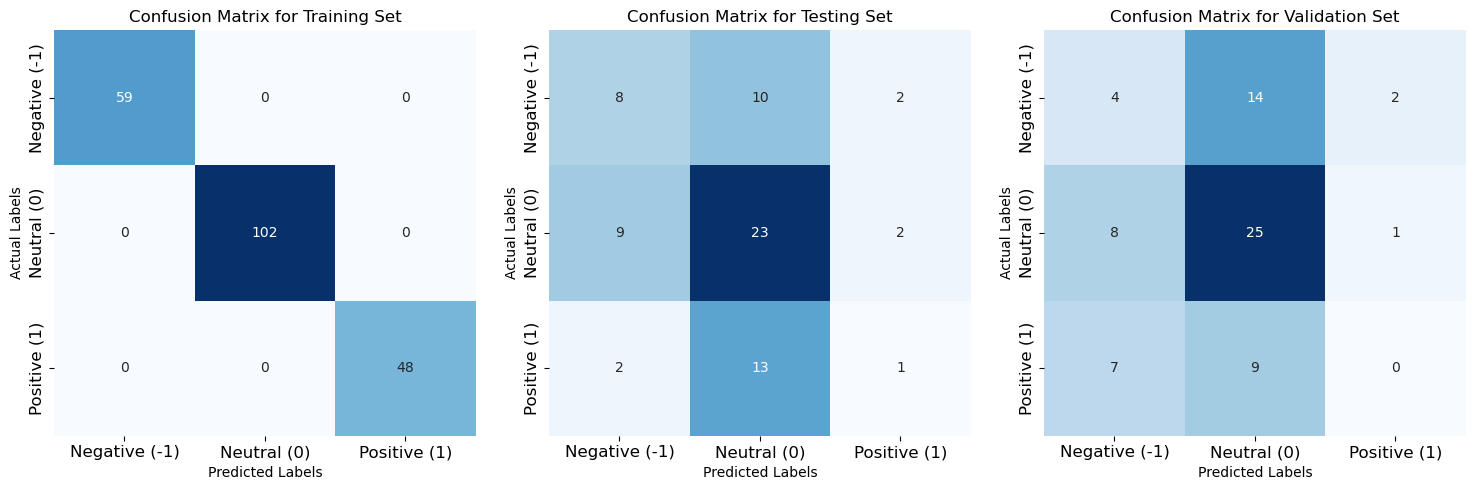

Confusion Matrix for Final Training Set:
 [[ 59   0   0]
 [  0 102   0]
 [  0   0  48]]
Confusion Matrix for Final Testing Set:
 [[ 8 10  2]
 [ 9 23  2]
 [ 2 13  1]]
Confusion Matrix for Final Validation Set:
 [[ 4 14  2]
 [ 8 25  1]
 [ 7  9  0]]


In [51]:
get_basic_model_metrics(random_forest_model_word2vec, X_train_word2vec, y_train, 
                        X_test_word2vec, y_test, X_val_word2vec, y_val, 'Word2Vec')

In [52]:
# Calculating different metrics
word2vec_base_train = model_performance(random_forest_model_word2vec, X_train_word2vec, y_train)
word2vec_base_test = model_performance(random_forest_model_word2vec, X_test_word2vec, y_test)
word2vec_base_val = model_performance(random_forest_model_word2vec, X_val_word2vec, y_val)

print("\nEvaluation Metrics -")
print("\n  Training Performance (Word2Vec) --->\n", word2vec_base_train)
print("\n  Testing Performance (Word2Vec) --->\n", word2vec_base_test)
print("\n  Validation Performance (Word2Vec) --->\n", word2vec_base_val)


Evaluation Metrics -

  Training Performance (Word2Vec) --->
   Accuracy  Recall Precision F1-Score
0   1.0000  1.0000    1.0000   1.0000

  Testing Performance (Word2Vec) --->
   Accuracy  Recall Precision F1-Score
0   0.4571  0.4571    0.4089   0.4183

  Validation Performance (Word2Vec) --->
   Accuracy  Recall Precision F1-Score
0   0.4143  0.4143    0.3131   0.3548


> * The Base model with Word2Vec embedding achieves very high accuracy, recall, precision, and F1-score on the training set. These scores indicate that the model has learned the training data very well or is highly overfitted which is very likely seeing the testing and validation set scores
> * It struggles on unseen data, with testing and validation accuracy below 50%, which reflects limited generalization capabilities
> * Also, lower precision and recall on both testing and validation sets highlight clear imbalances in correctly identifying the classes. We would need to further check on other two techniques and consider hyperparameter tuning as well

<u>**Basic ML Model - GloVe**

In [53]:
# Initializing the Random Forest model
random_forest_model_glove = RandomForestClassifier(class_weight = "balanced",
                                                   n_estimators = 10,
                                                   max_depth = 2,
                                                   bootstrap = True,
                                                   random_state = 42)
random_forest_model_glove

RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=10,
                       random_state=42)


 Time taken to train the RandomForest model for GloVe - 0.04 seconds

 Model -  RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=10,
                       random_state=42)

Confusion Matrices:


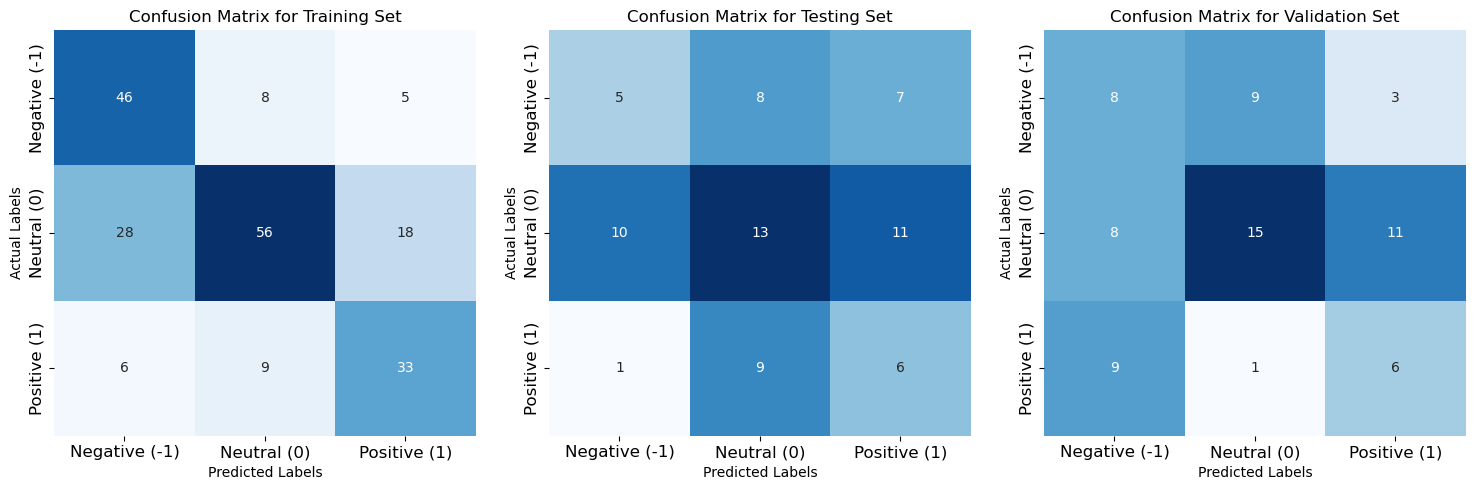

Confusion Matrix for Final Training Set:
 [[46  8  5]
 [28 56 18]
 [ 6  9 33]]
Confusion Matrix for Final Testing Set:
 [[ 5  8  7]
 [10 13 11]
 [ 1  9  6]]
Confusion Matrix for Final Validation Set:
 [[ 8  9  3]
 [ 8 15 11]
 [ 9  1  6]]


In [54]:
get_basic_model_metrics(random_forest_model_glove, X_train_glove, y_train, 
                        X_test_glove, y_test, X_val_glove, y_val, 'GloVe')

In [55]:
# Calculating different metrics
glove_base_train = model_performance(random_forest_model_glove, X_train_glove, y_train)
glove_base_test = model_performance(random_forest_model_glove, X_test_glove, y_test)
glove_base_val = model_performance(random_forest_model_glove, X_val_glove, y_val)

print("\nEvaluation Metrics -")
print("\n  Training Performance (GloVe) --->\n", glove_base_train)
print("\n  Testing Performance (GloVe) --->\n", glove_base_test)
print("\n  Validation Performance (GloVe) --->\n", glove_base_val)


Evaluation Metrics -

  Training Performance (GloVe) --->
   Accuracy  Recall Precision F1-Score
0   0.6459  0.6459    0.6720   0.6449

  Testing Performance (GloVe) --->
   Accuracy  Recall Precision F1-Score
0   0.3429  0.3429    0.3569   0.3453

  Validation Performance (GloVe) --->
   Accuracy  Recall Precision F1-Score
0   0.4143  0.4143    0.4514   0.4248


> * The training set accuracy and F1-score are moderate. This indicates that our model captures patterns reasonably well and is less likely to overfuit on the training set unlike the previous model
> * Both testing and validation accuracy are low, with poor precision and recall and shows how it struggles to generalize, especially in the testing confusion matrix
> * Overall, our model fails to balance precision and recall effectively, with significant drops in validation performance compared to training. We would need to consider hypertuning to refine our analysis

<u>**Basic ML Model - Sentence Transformer**

In [56]:
# Initializing the Random Forest model
random_forest_model_sentence_transformer = RandomForestClassifier(class_weight = "balanced",
                                                                   n_estimators = 10,
                                                                  max_depth = 2,
                                                                   bootstrap = True,
                                                                   random_state = 42)
random_forest_model_sentence_transformer

RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=10,
                       random_state=42)


 Time taken to train the RandomForest model for Sentence Transformer - 0.04 seconds

 Model -  RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=10,
                       random_state=42)

Confusion Matrices:


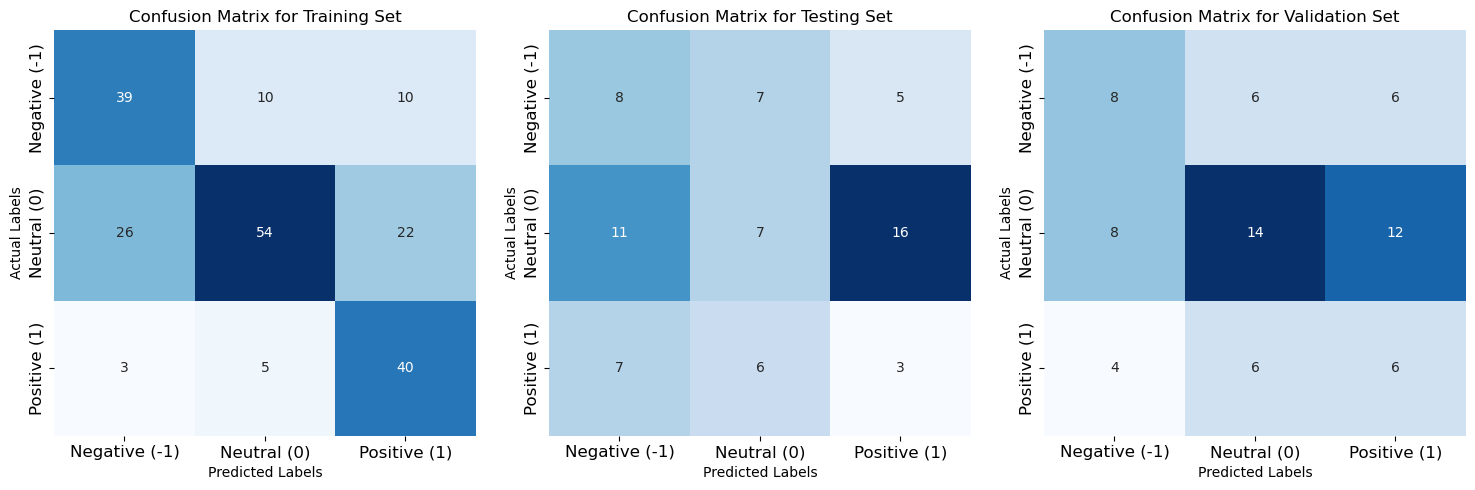

Confusion Matrix for Final Training Set:
 [[39 10 10]
 [26 54 22]
 [ 3  5 40]]
Confusion Matrix for Final Testing Set:
 [[ 8  7  5]
 [11  7 16]
 [ 7  6  3]]
Confusion Matrix for Final Validation Set:
 [[ 8  6  6]
 [ 8 14 12]
 [ 4  6  6]]


In [57]:
get_basic_model_metrics(random_forest_model_sentence_transformer, X_train_sentence_transformer, y_train, 
                        X_test_sentence_transformer, y_test, X_val_sentence_transformer, y_val, 'Sentence Transformer')

In [58]:
# Calculating different metrics
sen_transf_base_train = model_performance(random_forest_model_sentence_transformer, X_train_sentence_transformer, y_train)
sen_transf_base_test = model_performance(random_forest_model_sentence_transformer, X_test_sentence_transformer, y_test)
sen_transf_base_val = model_performance(random_forest_model_sentence_transformer, X_val_sentence_transformer, y_val)

print("\nEvaluation Metrics -")
print("\n  Training Performance (Sentence Transformer) --->\n", sen_transf_base_train)
print("\n  Testing Performance (Sentence Transformer) --->\n", sen_transf_base_test)
print("\n  Validation Performance (Sentence Transformer) --->\n", sen_transf_base_val)


Evaluation Metrics -

  Training Performance (Sentence Transformer) --->
   Accuracy  Recall Precision F1-Score
0   0.6364  0.6364    0.6714   0.6347

  Testing Performance (Sentence Transformer) --->
   Accuracy  Recall Precision F1-Score
0   0.2571  0.2571    0.2865   0.2596

  Validation Performance (Sentence Transformer) --->
   Accuracy  Recall Precision F1-Score
0   0.4000  0.4000    0.4330   0.4095


> * Our model's training accuracy and F1-score are moderate. This indicates that there is a a fair ability for our model to capture patterns during training
> * However, both testing and validation performance are poor, with low accuracy and F1-scores. Misclassifications are common across all classes, particularly in testing, showing limited model robustness on unseen data
> * Also, there seems to be a gap between training and testing/validation metrics which suggests overfitting in training set results though it seems to not when seen separately. This model also requires hyperparameter tuning like the previous two models

> Seeing these results for all 3 Random Forest Base Models for each of the Embedding Techniques, let's move on with Hyperparameter tuning for them one by one

### Perform Hyperparameter Tuning for the ML Model for the 3 Embedding Techniques

> Let's create some functions to make the task easier

In [59]:
# Using Grid Search to check performance of Random Forest with different hyperparameters

# Parameter grid for Grid Search

param_grid = {
    'n_estimators': np.arange(50, 110, 25), # the number of boosting stages to be run
    'criterion': ['gini', 'entropy'],
    'max_depth': list(np.arange(5, 30, 5)), # maximum depth of the random forest
    'min_samples_split': [2, 5, 10], # these are the maximim number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 5], # minimum number of samples required to be at the tree node
    'max_features': [0.3, 0.4], # this sets the maximum number of features to be considered for splitting
    'max_leaf_nodes': [None, 10, 20] #this is the maximum number of leaf nodes for random forest
}

In [60]:
# Perform Grid Search on a model

def perform_grid_search(model, parameters, X_train, y_train, embedding_name):
    """
    Performs a Grid Search for specific model
    along with time taken to fetch the best parameters
    
    Input Parameters:
    model: The model on which we need to perform GridSearch
    parameters: The parameters to do grid search
    X_train: Training set of independent variables
    y_train: Training set of target variable
    embedding_name: Type of word embedding used
    """
    
    # Initializing Grid Search
    # verbose = 1 will print the log inline while performing the search
    grid_search = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, n_jobs = -1, verbose = 1)

    model_name = model.__class__.__name__.replace('Classifier', '')
    
    # Training the model
    start_time_fit = time.time()
    grid_search.fit(X_train, y_train)
    end_time_fit = time.time()
    
    time_to_fit = end_time_fit - start_time_fit

    # Getting the best parameters found by Grid Search
    best_parameters = grid_search.best_params_
    print(f"\nBest Parameters found by Grid Search on {model_name} ({embedding_name}) Model - \n       ", best_parameters)
    
    if(time_to_fit < 60):
        print(f"\n{model_name} ({embedding_name}) Grid Search Tuning Time:", format((time_to_fit), '.2f'), "seconds") 
    else:
        print(f"\n{model_name} ({embedding_name}) Grid Search Tuning Time: ", 
              int(time_to_fit / 60), "minute(s)", int(time_to_fit % 60), "second(s)") 
    
    return grid_search

In [61]:
def get_best_model_metrics(model, X_train, y_train, X_test, y_test, X_val, y_val):
    
    # Training the model
    model.fit(X_train, y_train)
    
    # Prediction
    y_train_tuned_pred = model.predict(X_train)
    y_test_tuned_pred = model.predict(X_test)
    y_val_tuned_pred = model.predict(X_val)
    
    # Getting Confusion Matrix
    conf_matrix_train = confusion_matrix(y_train, y_train_tuned_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_tuned_pred)
    conf_matrix_val = confusion_matrix(y_val, y_val_tuned_pred)
    
    # Getting Evaluation metrics
    evaluation_metrics(y_train, y_train_tuned_pred, y_test, y_test_tuned_pred, y_val, y_val_tuned_pred, 
                       conf_matrix_train, conf_matrix_test, conf_matrix_val)

In [62]:
## Calculating feature importance based on the model
def check_feature_importance(best_model, X_train, embedding_name):
    '''
    Gets the feature importance for the specific model
    Input Parameters:
    best_model: The best calculated model from Grid Search
    X_train: Training set of independent variables
    embedding_name: Type of word embedding used
    '''
    ## Calculating feature importance 
    
    feature_importances = best_model.feature_importances_
    model_name = best_model.__class__.__name__.replace('Classifier', '')

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns,
                                          'Importance': feature_importances}).sort_values(by = 'Importance', ascending = False)

    plt.figure(figsize = (15, 8))
    sns.barplot(feature_importance_df, color = 'green', x = 'Feature', y = 'Importance')
    plt.title(f"Feature Importance for Telecom ({model_name} - {embedding_name})")
    plt.xticks(rotation = 90)
    plt.show()

                                          ***--- END OF FUNCTIONS SET - 2 ---***

<u>**Hyperparameter Tuning for ML Model - Word2Vec**

In [63]:
# Performing Grid Search
grid_search_random_forest_word2vec = perform_grid_search(random_forest_model_word2vec, param_grid,
                                                                X_train_word2vec, y_train, 'Word2Vec')

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits

Best Parameters found by Grid Search on RandomForest (Word2Vec) Model - 
        {'criterion': 'gini', 'max_depth': 5, 'max_features': 0.3, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

RandomForest (Word2Vec) Grid Search Tuning Time:  37 minute(s) 11 second(s)


> Concluding on the best parameters to further increase the performance on our Random Forest model with Word2Vec embedding as the above mentioned, we will proceed to tune our Random Forest model on them and check the evaluation metrics

In [64]:
best_model_word2vec = grid_search_random_forest_word2vec.best_estimator_
best_model_word2vec

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.3,
                       max_leaf_nodes=20, min_samples_split=5, n_estimators=50,
                       random_state=42)


Confusion Matrices:


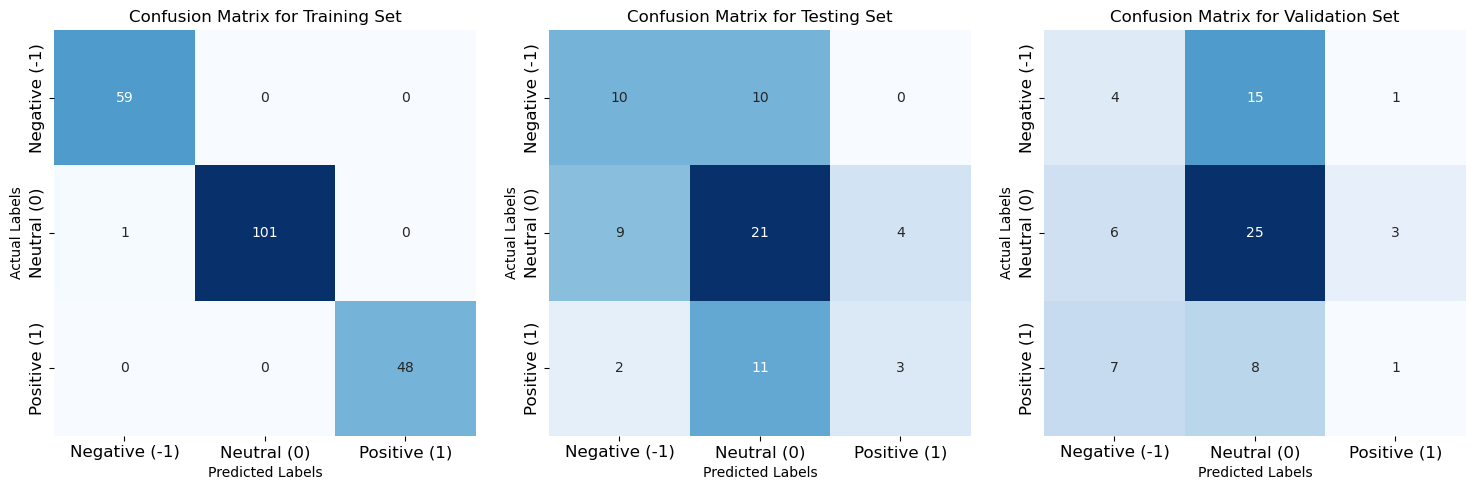

Confusion Matrix for Final Training Set:
 [[ 59   0   0]
 [  1 101   0]
 [  0   0  48]]
Confusion Matrix for Final Testing Set:
 [[10 10  0]
 [ 9 21  4]
 [ 2 11  3]]
Confusion Matrix for Final Validation Set:
 [[ 4 15  1]
 [ 6 25  3]
 [ 7  8  1]]


In [65]:
get_best_model_metrics(best_model_word2vec, X_train_word2vec, y_train, X_test_word2vec, y_test, X_val_word2vec, y_val)

In [66]:
# Calculating different metrics
word2vec_best_train = model_performance(best_model_word2vec, X_train_word2vec, y_train)
word2vec_best_test = model_performance(best_model_word2vec, X_test_word2vec, y_test)
word2vec_best_val = model_performance(best_model_word2vec, X_val_word2vec, y_val)

print("\nEvaluation Metrics -")
print("\n  Training Performance (Word2Vec) --->\n", word2vec_best_train)
print("\n  Testing Performance (Word2Vec) --->\n", word2vec_best_test)
print("\n  Validation Performance (Word2Vec) --->\n", word2vec_best_val)


Evaluation Metrics -

  Training Performance (Word2Vec) --->
   Accuracy  Recall Precision F1-Score
0   0.9952  0.9952    0.9953   0.9952

  Testing Performance (Word2Vec) --->
   Accuracy  Recall Precision F1-Score
0   0.4857  0.4857    0.4769   0.4674

  Validation Performance (Word2Vec) --->
   Accuracy  Recall Precision F1-Score
0   0.4286  0.4286    0.3659   0.3797


> * The model demonstrates high accuracy, recall, and precision on the training data, which shows that it has learned the training set well. However, this might also suggest overfitting
> * The testing and validation metrics remain modest, showing a slight improvement compared to the base model
>
> Overall, the tuned model exhibits a consistent performance trend across all 3 sets - training, testing and validation, which suggests the tuning process's positive impact on capturing patterns

<u>**Hyperparameter Tuning for ML Model - GloVe**

In [67]:
# Performing Grid Search
grid_search_random_forest_glove = perform_grid_search(random_forest_model_glove, param_grid,
                                                                X_train_glove, y_train, 'GloVe')

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits

Best Parameters found by Grid Search on RandomForest (GloVe) Model - 
        {'criterion': 'gini', 'max_depth': 10, 'max_features': 0.4, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 75}

RandomForest (GloVe) Grid Search Tuning Time:  23 minute(s) 15 second(s)


> Concluding on the best parameters to further increase the performance on our Random Forest model with GloVe embedding as the above mentioned, we will proceed to tune our Random Forest model on them and analyse on the evaluation metrics

In [68]:
best_model_glove = grid_search_random_forest_glove.best_estimator_
best_model_glove

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.4,
                       max_leaf_nodes=20, min_samples_leaf=5, n_estimators=75,
                       random_state=42)


Confusion Matrices:


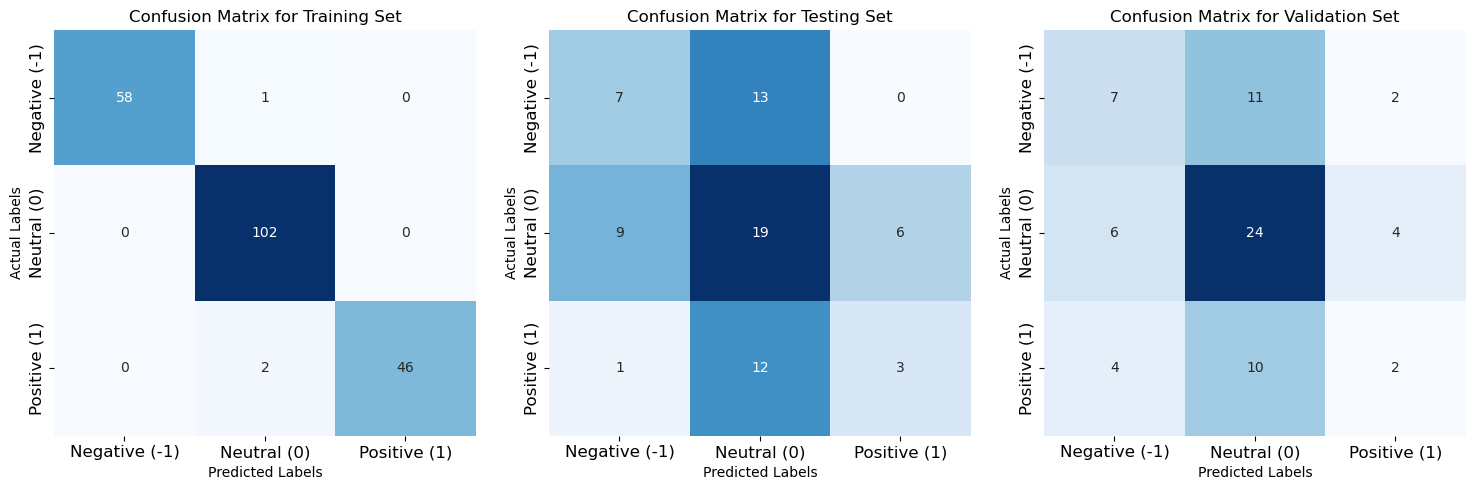

Confusion Matrix for Final Training Set:
 [[ 58   1   0]
 [  0 102   0]
 [  0   2  46]]
Confusion Matrix for Final Testing Set:
 [[ 7 13  0]
 [ 9 19  6]
 [ 1 12  3]]
Confusion Matrix for Final Validation Set:
 [[ 7 11  2]
 [ 6 24  4]
 [ 4 10  2]]


In [69]:
get_best_model_metrics(best_model_glove, X_train_glove, y_train, X_test_glove, y_test, X_val_glove, y_val)

In [70]:
# Calculating different metrics
glove_best_train = model_performance(best_model_glove, X_train_glove, y_train)
glove_best_test = model_performance(best_model_glove, X_test_glove, y_test)
glove_best_val = model_performance(best_model_glove, X_val_glove, y_val)

print("\nEvaluation Metrics -")
print("\n  Training Performance (GloVe) --->\n", glove_best_train)
print("\n  Testing Performance (GloVe) --->\n", glove_best_test)
print("\n  Validation Performance (GloVe) --->\n", glove_best_val)


Evaluation Metrics -

  Training Performance (GloVe) --->
   Accuracy  Recall Precision F1-Score
0   0.9856  0.9856    0.9861   0.9856

  Testing Performance (GloVe) --->
   Accuracy  Recall Precision F1-Score
0   0.4143  0.4143    0.4036   0.3996

  Validation Performance (GloVe) --->
   Accuracy  Recall Precision F1-Score
0   0.4714  0.4714    0.4338   0.4413


> * The tuned model with GloVe embedding achieves a near-perfect training F1-score, which indicates it has effectively learned the training data. However, the perfect scores might suggest overfitting and still be a concern
> * The testing and validation metrics show minor improvements over the base model we analysed previously, particularly in accuracy and F1-score however, confusion matrix data shows misclassifications across the classes which means though better than the base model, the model still struggles to perform well on unseen data
> 
> Overall, compared to the base Word2Vec model, the tuned model achieves higher validation accuracy and F1-score, highlighting improved generalization on unseen data

<u>**Hyperparameter Tuning for ML Model - Sentence Transformer**

In [71]:
# Performing Grid Search
grid_search_random_forest_sentence_transformer = perform_grid_search(random_forest_model_sentence_transformer, param_grid,
                                                                X_train_sentence_transformer, y_train, 'Sentence Transformer')

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits

Best Parameters found by Grid Search on RandomForest (Sentence Transformer) Model - 
        {'criterion': 'entropy', 'max_depth': 5, 'max_features': 0.4, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

RandomForest (Sentence Transformer) Grid Search Tuning Time:  60 minute(s) 21 second(s)


> Concluding on the best parameters to further increase the performance on our Random Forest model with Sentence Transformer embedding as the above mentioned, we will proceed to tune our Random Forest model on them and conduct an analysis on the evaluation metrics

In [72]:
best_model_sentence_transformer = grid_search_random_forest_sentence_transformer.best_estimator_
best_model_sentence_transformer

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_features=0.4, max_leaf_nodes=20,
                       n_estimators=50, random_state=42)


Confusion Matrices:


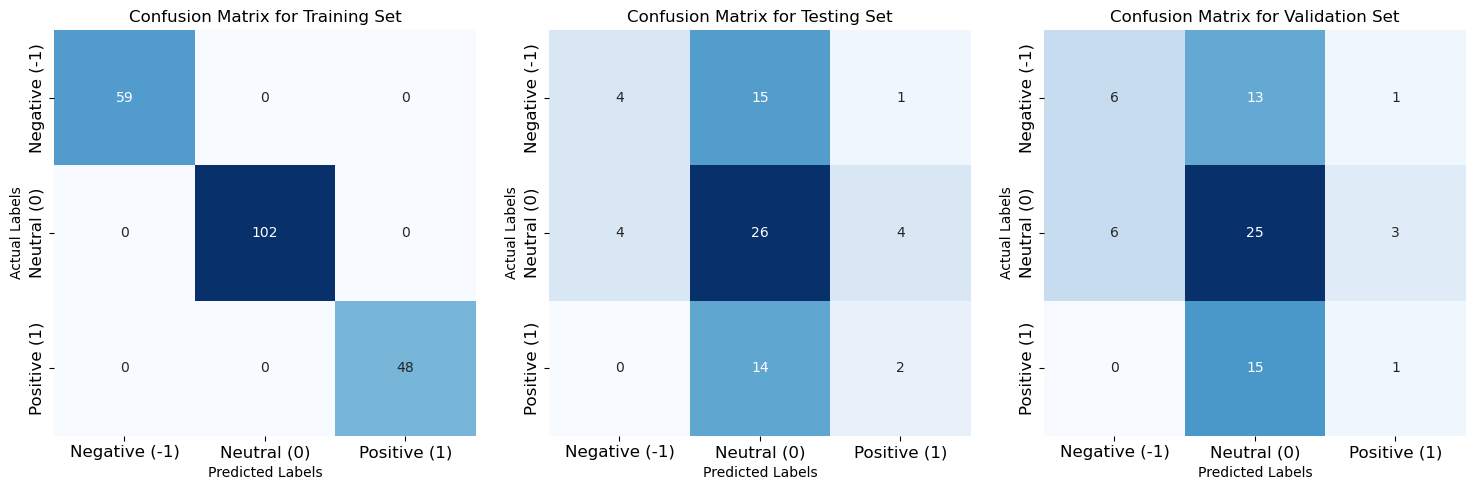

Confusion Matrix for Final Training Set:
 [[ 59   0   0]
 [  0 102   0]
 [  0   0  48]]
Confusion Matrix for Final Testing Set:
 [[ 4 15  1]
 [ 4 26  4]
 [ 0 14  2]]
Confusion Matrix for Final Validation Set:
 [[ 6 13  1]
 [ 6 25  3]
 [ 0 15  1]]


In [73]:
get_best_model_metrics(best_model_sentence_transformer, X_train_sentence_transformer, y_train, 
                       X_test_sentence_transformer, y_test, X_val_sentence_transformer, y_val)

In [74]:
# Calculating different metrics
sen_transf_best_train = model_performance(best_model_sentence_transformer, X_train_sentence_transformer, y_train)
sen_transf_best_test = model_performance(best_model_sentence_transformer, X_test_sentence_transformer, y_test)
sen_transf_best_val = model_performance(best_model_sentence_transformer, X_val_sentence_transformer, y_val)

print("\nEvaluation Metrics -")
print("\n  Training Performance (Sentence Transformer) --->\n", sen_transf_best_train)
print("\n  Testing Performance (Sentence Transformer) --->\n", sen_transf_best_test)
print("\n  Validation Performance (Sentence Transformer) --->\n", sen_transf_best_val)


Evaluation Metrics -

  Training Performance (Sentence Transformer) --->
   Accuracy  Recall Precision F1-Score
0   1.0000  1.0000    1.0000   1.0000

  Testing Performance (Sentence Transformer) --->
   Accuracy  Recall Precision F1-Score
0   0.4571  0.4571    0.4378   0.4052

  Validation Performance (Sentence Transformer) --->
   Accuracy  Recall Precision F1-Score
0   0.4571  0.4571    0.4177   0.4081


> * This one achieves perfect accuracy and F1-score on the training set, with no misclassifications. However, this indicates overfitting, as it  may have memorized the training data rather than generalizing well
> * Testing and validation metrics show slight improvements compared to the base model, with increased precision and F1-score
> 
> Overall, the tuned model outperforms the base model on testing and validation metrics, with slight gaps still needed to be filled with tuning further, if required

### Comment on Model Performance across different Metrics

> All metrics were evaluated and the model performance is updated for each alongside the metrics
>
> Confusion Matrix also displayed for each of the model - base and tuned
>
> However, let's check on the training set performance across all the models summed up together

In [75]:
# Training set performance comparison

training_set = pd.concat(
    [word2vec_base_train.T,
     glove_base_train.T,
     sen_transf_base_train.T,
     word2vec_best_train.T,
     glove_best_train.T,
     sen_transf_best_train.T,
     ], axis = 1
)

training_set.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training Set Performance Comparison:")
training_set

Training Set Performance Comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0000,0.6459,0.6364,0.9952,0.9856,1.0000
Recall,1.0000,0.6459,0.6364,0.9952,0.9856,1.0000
Precision,1.0000,0.6720,0.6714,0.9953,0.9861,1.0000
F1-Score,1.0000,0.6449,0.6347,0.9952,0.9856,1.0000


> * We see most almost all the values for evaluation metrics - Accuracy, Precision, Recall and F1-Score are close to perfection. This indicates that the models might be overfitted. Further performance analysis needs to be done to regularise this
>
> * **GloVe** and **Sentence Transformer** models for both base model demonstrate moderate performance, with GloVe slightly ahead in precision and F1-Score. This might feel realistic as the model performance improves with hypertuning the parameters
>
> * **GloVe** and **Sentence Transformer** models also face challenges in accurately distinguishing between classes which we can see from their higher misclassifications
>
> * **Word2Vec** model over performs indicating a highly overfit model
>
> * The perfect performance of some tuned models raises concerns about potential overfitting, as they are not generalizing well on unseen data which we will comment on in later code
> 
> Overall, while the tuned models for all 3 embedding techniques appear to perform flawlessly on the training set, let's dig deep further into evaluating the same peformances on the validation and test sets to confirm their generalizability

### Choose the Best Model from the ones built with Proper Reasoning

In [76]:
#validation performance comparison

validation_set = pd.concat(
    [word2vec_base_val.T,
     glove_base_val.T,
     sen_transf_base_val.T,
     word2vec_best_val.T,
     glove_best_val.T,
     sen_transf_best_val.T,
     ], axis = 1
)

validation_set.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation Set Performance Comparison:")
validation_set

Validation Set Performance Comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.4143,0.4143,0.4000,0.4286,0.4714,0.4571
Recall,0.4143,0.4143,0.4000,0.4286,0.4714,0.4571
Precision,0.3131,0.4514,0.4330,0.3659,0.4338,0.4177
F1-Score,0.3548,0.4248,0.4095,0.3797,0.4413,0.4081


> Now, when choosing the best model, considering Validation set performance is the ideal choice as the validation set serves as a proxy for our unseen data and thus, provides an unbiased estimate of our model's performance
> Hence, we have listed the valudation set perfromance in a tabular form for all the 3 embedding techniques along with the models' hypertuned performances.
> From this, we can say below points:
>  * **Accuracy:** While accuracy measures the overall correctness of the predictions, it is not playing a good role in our dataset as our dataset is imbalanced with more inclination towards the Neutral class.
>      - The tuned gloVe model has the highest accuracy in the validation set
>      - However, we shouldn't only focus on accuracy for determining the best model
>  * **Recall:** 
>      - The Tuned GloVe model shows the highest recall indicating it is able to identify the relevant instances and is able to capture the sentiments the most among other models
>      - While the other two tuned models also give a comparable result, Tuned GloVe model outshines them to be on top
>  * **Precision:** 
>      - The Base GloVe model has the best precision followed by the Tuned GloVe model which shows a competitive performance
>      - This shows that while a little less than the base model, the Tuned GloVe model correctly predicts the positive instances while also avoiding the false positives
> <br>
>  * **F1-Score:** Since, F1-Score is represented as the mean of Precision and Recall, it gives an accurate understanding on the model performance specially in our kind of imbalanced set
>      - We see that the F1-score of Tuned GloVe model is the best among all others
>      - Though, the Precision values are less for the tuned model as compared to the basic GloVe model, higher value of Recall balances it out making the overall F1-score slighly better for the tuned one and making it a good choice
>      - This also says that our model is able to identify the false postives and false negatives
>
>
> Further, let's also dig in w.r.t. the embedding techniques:
>  * **Word2Vec:**
>      - <u>Base Model</u>: This one struggles across accuracy, recall, and precision metrics and the confusion matrix also doesn't show a good classification of the categories
>      - <u>Tuned Model</u>: It shows better values  as compared to the base model, specially in Recall. However, since there is a drop in the precision value when Recall is increased, it affects the F1-score to reduce significantly
>  * **GloVe:**
>      - <u>Base Model</u>: Out of all the 3 embedding technique base models, basic GloVe model gives the highest perfromance when taking about F-score, precision, recall and accuracy. Though the confusion matrix struggles, it manages to highlight the false and true predictions better compared to other 2
>      - <u>Tuned Model</u>: We see a good improvement in the metric values in the tuned model. Though it still struggles to manage a good F1-score, the Tuned GloVe model outperforms other 2 counter parts
>  * **Sentence Transformer:**
>      - <u>Base Model</u>: We see the Sentence transformer base model is marginally better in performance when compared with the Word2Vec and has a consitent performance over the validation set, however it still lags in certain areas from the base GloVe model
>      - <u>Tuned Model</u>: There is a significant improvement post tuning the model but still struggles to manage the same consistency in Precision score due to which it lags in the F1-Score and lands far from Tuned GloVe model
> 
>
> **Final Selection of Best Model -**
> <br>From the above reasonings and analsyis, we can say that the <u>**Tuned GloVe**</u> model can be chosen as the best model based on the metrics performance evaluation overall
>  * It consistently balances recall, precision, and F1-score, ensuring good generalization
>  * Post-tuning, it shows clear improvements in handling all classes, as reflected in its confusion matrix
>  * Unlike Word2Vec and Sentence Transformer, which show inconsistencies across their performance, GloVe maintains stability and reliability across
> 
>
> Therefore, overall, the **Tuned GloVe** model is the best choice due to its superior F1-score, robust handling of imbalanced sentiment classes, and ability to generalize effectively to the 3 class ditributions in the dataset inspite of being an imbalanced set

### Check the Performance of the Final Model on the Test Set 

In [77]:
print("\nPerformance of Tuned GloVe Model on Test Set --->\n\n", glove_best_test)


Performance of Tuned GloVe Model on Test Set --->

   Accuracy  Recall Precision F1-Score
0   0.4143  0.4143    0.4036   0.3996


In [78]:
y_test_best_pred = best_model_glove.predict(X_test_glove)
conf_matrix_test = confusion_matrix(y_test, y_test_best_pred)

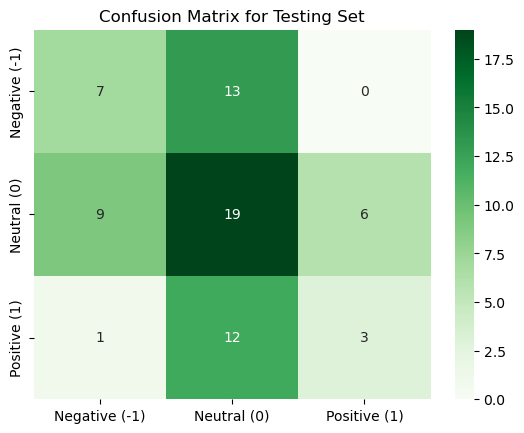

Confusion Matrix for Final Testing Set:
 [[ 7 13  0]
 [ 9 19  6]
 [ 1 12  3]]


In [79]:
figsize = (15, 5)

# Labels for the confusion matrix
labels = ['Negative (-1)', 'Neutral (0)', 'Positive (1)']
    
plt.title('Confusion Matrix for Testing Set')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

sns.heatmap(conf_matrix_test, annot = True, fmt = 'd', cmap = 'Greens', 
            xticklabels = labels, yticklabels = labels, cbar = True)
plt.show()

print("Confusion Matrix for Final Testing Set:\n", conf_matrix_test)

* As we have seen in the validation set, the test set for our best model, i.e., the **Tuned GloVe model** also demonstrates consistent performance across key evaluation metrics (accuracy, recall, precision, and F1-score). This balance indicates our model's ability to identify relevant patterns without overfitting or underperforming
* We also see that while our model can reasonably predict positive and negative events, its performance indicates room for improvement in effectively distinguishing between these minority classes. We can explore on fine tuning it with more variables or introducing ensemble techniques like over or under sampling
* The business inplications for the testing set performance can also be analysed further with below points:
    * **Positive Events:** The model does a decent job at spotting opportunities, but sharpening its ability to pick up on positive events could help businesses seize growth chances more effectively
    * **Negative Events:** Catching negative events quickly and accurately is crucial to staying ahead of potential risks. Improving this aspect would give businesses more confidence in their decisions and help them act proactively

Overall, while our Tuned GloVe model performs reasonably well, its current strengths lie in handling the neutral class very effectively. Also, there are opportunities to improve its performance on the more critical positive and negative classes

***

# <u>Content Summarization</u>

###  Group the data at a Week-Level

> Since we did a lot of data pre-processing on our initially loaded 'stock_news' dataset, we will load the dataset again for this part of questions
>
> Although all the preprocessing was done on a separately created column, 'Cleaned_News', it is still better that we load a fresh dataset again to continue with our question parts
>
> We will name this one as **new_stock_news**

In [80]:
# loading the dataset again to avoid any effects from previous data changes
new_stock_news = pd.read_csv("C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 10 -  Natural Language Processing (Week 38 to Week 42)/Project/stock_news.csv")

float_columns = ['Open', 'Close', 'Low', 'High']  # Replace with actual float column names
new_stock_news[float_columns] = new_stock_news[float_columns].round(3)

new_stock_news.head(10)

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.74,42.245,41.482,40.247,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.74,42.245,41.482,40.247,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.74,42.245,41.482,40.247,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.74,42.245,41.482,40.247,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.74,42.245,41.482,40.247,130672400,-1
5,2019-01-02,Apple CEO Tim Cook discussed the company's Q1 ...,41.74,42.245,41.482,40.247,130672400,0
6,2019-01-02,Roku Inc has announced plans to offer premium...,41.74,42.245,41.482,40.247,130672400,1
7,2019-01-02,Wall Street saw modest gains on Wednesday but...,41.74,42.245,41.482,40.247,130672400,-1
8,2019-01-02,Apple's fiscal first quarter revenue came in ...,41.74,42.245,41.482,40.247,130672400,-1
9,2019-01-02,Apple Inc. lowered its quarterly sales foreca...,41.74,42.245,41.482,40.247,130672400,-1


In [81]:
new_stock_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


> Now, we see that the Date column is of Object type. We'll change it to DateTime type in order to group our data on a weekly level. We will use the **to_datetime** function for this

In [82]:
new_stock_news['Date'] = pd.to_datetime(new_stock_news['Date'])

new_stock_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


> Now that we have changed the datatype to datetime, we will now proced to create a new column, **Week**. We will be adding the Weekly grouping in this column

In [83]:
# Adding a week column for grouping
new_stock_news['Week'] = new_stock_news['Date'].dt.to_period('W')

label_mapping = {0: 'Neutral', -1: 'Negative', 1: 'Positive'}

# Grouping the data at a week-level and aggregate
weekly_stock_news = new_stock_news.groupby('Week').agg({
    'News': lambda x: ' || '.join(f"{date.strftime('%Y-%m-%d')} ({label_mapping[label]}){news}"
        for date, news, label in zip(
            new_stock_news.loc[x.index, 'Date'], 
            x, new_stock_news.loc[x.index, 'Label'])),
    'Open': 'mean',
    'High': 'mean',
    'Low': 'mean',
    'Close': 'mean',
    'Volume': 'sum'
}).reset_index()

weekly_stock_news.head(20)

,Week,News,Open,High,Low,Close,Volume
0,2018-12-31/2019-01-06,2019-01-02 (Negative) The tech sector experien...,43.911923,44.166654,43.498346,42.631654,5843148000
1,2019-01-07/2019-01-13,2019-01-07 (Positive) Sprint and Samsung plan ...,54.874613,55.742710,54.091129,53.329581,4776854800
2,2019-01-14/2019-01-20,2019-01-14 (Negative) The U.S. stock market de...,38.041000,38.555655,37.849586,37.066276,3561556800
3,2019-01-21/2019-01-27,2019-01-22 (Negative) The Swiss National Bank ...,38.852810,39.057333,38.129524,37.221000,2386096000
4,2019-01-28/2019-02-03,2019-01-28 (Negative) Caterpillar Inc reported...,40.052778,40.670639,39.457556,38.937250,7005030800
5,2019-02-04/2019-02-10,2019-02-04 (Positive) The Dow Jones Industrial...,50.925667,51.583533,50.564800,49.556000,1782770400
6,2019-02-11/2019-02-17,"2019-02-12 (Neutral) This week, the European U...",50.717000,50.994278,50.232167,49.188444,1650455600
7,2019-02-18/2019-02-24,2019-02-19 (Positive) This news article discus...,42.814000,43.191750,42.682125,41.721875,678567200
8,2019-02-25/2019-03-03,2019-02-25 (Positive) The Dow Jones Industrial...,43.474889,43.903000,43.397556,42.328111,815925600
9,2019-03-04/2019-03-10,"2019-03-04 (Neutral) Spotify, the world's larg...",46.797600,47.303500,45.948200,45.338300,1275180800


> Here, we have formatted the news column in such a way that even though the news is grouped by Week, we can still see a clear separation of news by the dates as well. Now the News is displayed in below way:
> * Each News has its Date prefixed
> * This also comprises of the Sentiment Label alongside the Date
>     - Neutral for 0 Label class
>     - Negative for -1 label class
>     - Positive for 1 label class

> Our new Weekly-Grouped stock_news dataset now:
> * Groups our dataset by the Week column,
> * Aggregates the News column by concatenating all news articles from the same week, adding sentiment label and date for clarity,
> * Calculates the mean for numerical columns (Open, High, Low, and Close) to summarize weekly trends,
> * and Sums up Volume to get the total trading volume for the week


In [84]:
# Example News for weekly aggregation
weekly_stock_news["News"].iloc[0]

'2019-01-02 (Negative) The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. || 2019-01-02 (Negative) Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 || 2019-01-02 (Negative) Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian

> This way we can still see a clear separation of News by the Day while maintaining the weekly aggregation

###  Load the Large Language Model from Hugging Face

In [85]:
# Install llama-cpp-python with CUBLAS
!set LLAMA_CUBLAS=1
!set CMAKE_ARGS=-DLLAMA_CUBLAS=on
!set FORCE_CMAKE=1

# Install llama-cpp-python, cuda-enabled package
!python -m pip install llama-cpp-python -q

print("Installation for GPU llama-cpp-python successful!!!")

Installation for GPU llama-cpp-python successful!!!


In [86]:
!pip install transformers huggingface_hub tqdm -q

> We will now start with loading the **Mistral Model**. 
> <br> The **Mistral model** is a large language model (LLM) designed for various NLP tasks. This model is trained to understand and generate human language, thus this can be useful in our Stock Market Sentiment Analaysis. It can help us analyze the news articles, understanding their content, and making decisions based on that
> * It is designed to analyse large amount of text like in our case of weekly grouped news which contain more number of lines which can help us detect patterns and predict stock prices based on sentiment label or events
> * We are using the **Q6_K.gguf version** which is the **quantized form** of the Mistral model. This will make our model smaller and faster so it will be able to run effectively and efficiently while consuming less memory
> * It is well-suited to understand and process text which makes it a good model for analyzing stock-related news in our dataset

In [87]:
# Load Mistral model
model_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

In [88]:
model_path = hf_hub_download(
    repo_id = model_path,
    filename = model_basename
)
model_path

'C:\\Users\\pri96\\.cache\\huggingface\\hub\\models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF\\snapshots\\3a6fbf4a41a1d52e415a4958cde6856d34b2db93\\mistral-7b-instruct-v0.2.Q6_K.gguf'

> **What did we do here?**
> <br> We are downloading the Quantized mistral model here. The function used downloads the model file from the Hugging Face Hub to our local system
> * **repo_id** specifies the model’s repository
> * **filename** specifies the exact file we want to download from the Hugging Face Hub
> * **model_path** function returns the path to the downloaded model, which we will use to load it later

> Now that the model is downloaded, we will proceed with initializing the Llama model with the Quantized Mistral model file

In [89]:
start_time = time.time()
llm = Llama(
    model_path = model_path,    # Path to the downloaded quantized model
    n_gpu_layers = 100,         # Number of layers to transfer to the GPU for faster processing
    n_ctx = 5000,               # Context window size (how much input context is considered for generating output)
)
end_time = time.time()

total_time = end_time - start_time

print("\n Time taken to load LLM Model - ", format((total_time), '.2f'), "seconds") 
    
llm

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6, VMM: yes
llama_model_load_from_file: using device CUDA0 (NVIDIA GeForce RTX 3050 Laptop GPU) - 3303 MiB free
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from C:\Users\pri96\.cache\huggingface\hub\models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF\snapshots\3a6fbf4a41a1d52e415a4958cde6856d34b2db93\mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              =

llama_kv_cache_init: layer 16: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 17: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 18: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 19: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 20: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 21: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 22: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 23: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 24: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 25: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 26: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 27: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 28: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 29: n_embd_k_gqa = 1024, n_embd_v_gqa


 Time taken to load LLM Model -  17.56 seconds


CUDA : ARCHS = 860 | USE_GRAPHS = 1 | PEER_MAX_BATCH_SIZE = 128 | CPU : SSE3 = 1 | SSSE3 = 1 | AVX = 1 | AVX2 = 1 | F16C = 1 | FMA = 1 | LLAMAFILE = 1 | OPENMP = 1 | AARCH64_REPACK = 1 | 
Model metadata: {'general.name': 'mistralai_mistral-7b-instruct-v0.2', 'general.architecture': 'llama', 'llama.context_length': '32768', 'llama.rope.dimension_count': '128', 'llama.embedding_length': '4096', 'llama.block_count': '32', 'llama.feed_forward_length': '14336', 'llama.attention.head_count': '32', 'tokenizer.ggml.eos_token_id': '2', 'general.file_type': '18', 'llama.attention.head_count_kv': '8', 'llama.attention.layer_norm_rms_epsilon': '0.000010', 'llama.rope.freq_base': '1000000.000000', 'tokenizer.ggml.model': 'llama', 'general.quantization_version': '2', 'tokenizer.ggml.bos_token_id': '1', 'tokenizer.ggml.unknown_token_id': '0', 'tokenizer.ggml.padding_token_id': '0', 'tokenizer.ggml.add_bos_token': 'true', 'tokenizer.ggml.add_eos_token': 'false', 'tokenizer.chat_template': "{{ bos_toke

> This will initialize the Llama model and sets the parameters for running inference
> * **model_path** gives the path to the quantized model file that we downloaded
> * **n_gpu_layers** determines how many layers of the model will be moved to the GPU for faster processing
> * **n_ctx** defines how many words/tokens to be considered by the model in the text processing when generating a response. Using 4500 here to allow our model to consider more text at once as we have grouped the whole week's news into 1

###  Create a Function to Define the Model Parameters and Generate a Response

> In this one, we will create a function to encapsulate the logic to interact with our LLM Mistral model. The function will accept the model, input text, and a prompt template. It will then use the same model to generate a response based on the input prompt we pass to it
>
> The function also accepts the max_tokens parameter which tell the model about the maximum number of token limit for output response

In [90]:
def generate_summary_from_model(llm, news_text, prompt_template, max_tokens = 5000):
    """
    Generate a summary of the week's top positive and negative events. Also has a dynamic adjustment for lengthy inputs

    Parameters:
    llm: The preloaded large language model
    news_text: Concatenated news grouped by the week
    prompt_template: A formatted prompt template to generate a response
    max_tokens: Limit for model's output
    
    Returns: A JSON formatted reponse for Positive Events and Negative Events
    """
    # To format the prompt with the weekly news text
    prompt = prompt_template.format(news_text = news_text)

    # Using the LLM model to generate a response
    try:
        response = llm(prompt, max_tokens = max_tokens)
        
        # Extracting the text part of the response
        summary_text = response['choices'][0]['text'].strip()

        # Parse the extracted text as JSON
        # print("LLM Response:", summary_text)
        try:
            final_response = json.loads(summary_text)
            print("Response extracted successfully!!!")
            return final_response
        
        except json.JSONDecodeError:
            print("Incomplete JSON detected. Attempting to repair...")
            
            # Attempt to repair the JSON
            repaired_text = summary_text.rstrip(", \n") + "}"  # Close the JSON structure
            
            try:
                repaired_json = json.loads(repaired_text)
                print("Output JSON repaired successfully!!!")
                return repaired_json
            
            except json.JSONDecodeError:
                print("Failed to repair full JSON. Returning empty results and going for next record!!!")
                return {"Positive Events": [], "Negative Events": []}
    
    #except json.JSONDecodeError:
    #    print(f"Error decoding response: {response}")
    #    return {"Positive Events": [], "Negative Events": []}
    
    except Exception as e:
        # If the model response is not valid JSON, it will return an empty result with a warning
        print(f"Unexpected Error: {e} \n Returning empty results and going for next record!!!")
        return {"Positive Events": [], "Negative Events": []}


> Here, we have also added error handling so that if there is a JSON formatting issue or any other unforseen error, instead of the code getting crashed, it generates an empty response with placeholders for "Positive Events" and "Negative Events"

###  Define the Instruction for the Task 
#### &emsp;&emsp;&emsp; (the task is to identify the top three positive and negative events from the week that are likely to impact the stock price)

> To achieve this, we will create a prompt template which will be later provided to our above crerated function and will be used to create the desired response, ensuring it understands the requirements and returns the results in our expected format.

In [91]:
prompt_template = """
    You are an expert financial data analyst specializing in stock market news analysis.
    
    **Task:** Analyze the weekly news headlines provided below. Identify the **top three positive events** and the **top three negative events** most likely to impact stock prices, and output the results in strict JSON format.

    **Instructions:**
    1. Read the weekly news headlines carefully.
    2. Identify the **three most positive events** and **three most negative events** based on their potential impact on stock prices.
    3. **Prioritize events by significance**: List the most impactful events first within each category.
    4. Focus on clarity and conciseness. Write only the essential part of each event.
    5. **Do not include any commentary, explanation, or extra text.** Only return a valid JSON object.

    **Output Format:**
    Return a JSON object with the following structure:
    {{
    "Positive Events": [
    "Positive event 1",
    "Positive event 2",
    "Positive event 3"
    ],
    "Negative Events": [
    "Negative event 1",
    "Negative event 2",
    "Negative event 3"
    ]
    }}

    Ensure that:
    - The JSON object is syntactically valid.
    - There are **exactly three events in each list.** Use placeholders like "No significant event identified" if fewer than three events exist.

    **Weekly News:**
    {news_text}

    **Reminder:** Return only the JSON object. Do not include any extra text or explanations in the output.
    """

prompt_template

'\n    You are an expert financial data analyst specializing in stock market news analysis.\n    \n    **Task:** Analyze the weekly news headlines provided below. Identify the **top three positive events** and the **top three negative events** most likely to impact stock prices, and output the results in strict JSON format.\n\n    **Instructions:**\n    1. Read the weekly news headlines carefully.\n    2. Identify the **three most positive events** and **three most negative events** based on their potential impact on stock prices.\n    3. **Prioritize events by significance**: List the most impactful events first within each category.\n    4. Focus on clarity and conciseness. Write only the essential part of each event.\n    5. **Do not include any commentary, explanation, or extra text.** Only return a valid JSON object.\n\n    **Output Format:**\n    Return a JSON object with the following structure:\n    {{\n    "Positive Events": [\n    "Positive event 1",\n    "Positive event 2",\

> **NOTE:** We have used the same prompt template given in the Learner's Notebook however, we have modified the words a bit to make it follow the instructions more clearly and generate the desired output

###  Apply the Response Generation Function to get an output from the Model

> Now that we have created our function to generate the response for the given text as per the provided prompt, we will start with the next step where we will call this function in iterating loop to go through each of our Weekly Grouped Stock News dataset and generate a response for each record.
>
> For this, we have created a loop for iterating over the weekly_stock_news dataset (used **'\_'** as the delimiter for excluding index values during iteration) which calls the **generate_summary_from_model()** to generate positive and negative event summaries
>
> We will also append the week's stock statistics summary (Open, High, Low, etc.) to the results list

In [92]:
results = []
i = 0
overall_start_time = time.time()
# Loop through each week in the grouped DataFrame
for _, row in weekly_stock_news.iterrows():
    news_text = row['News']  # Extract concatenated news for the week
    
    i = i + 1
    print(f"\nProcessing record for Week - {i} from Weekly Grouped Stock News Data")
    
    start_time = time.time()
    
    # Applying the response generation function created previously to get an output from the LLM model
    summary = generate_summary_from_model(llm, news_text, prompt_template)
    
    end_time = time.time()
    
    total_time = end_time - start_time
    
    if total_time < 3600:
        print(f"\n    Time taken to process record for Week - {i} :", 
              int(total_time / 60), "minute(s)", int(total_time % 60), "second(s)")
        print("\n***************************************************")
    else:
        hours = total_time // 3600
        minutes = (total_time % 3600) / 60
        seconds = total_time % 60
        print(f"\n   Time taken to process record for Week - {i} :", 
          int(hours), "hour(s)", int(minutes), "minute(s)", int(seconds), "second(s)")
        print("\n***************************************************")
        
    # Append the results to the list
    results.append({
        'Week': row['Week'],
        'Positive Events': summary.get('Positive Events', []),
        'Negative Events': summary.get('Negative Events', []),
        'Open': round(row['Open'], 2),
        'High': round(row['High'], 2),
        'Low': round(row['Low'], 2),
        'Close': round(row['Close'], 2),
        'Volume': row['Volume']
    })

overall_end_time = time.time()

total_time = overall_end_time - overall_start_time

if total_time < 3600:
    print("\n\nTotal Time taken to generate response out of the provided prompt -", 
          int(total_time / 60), "minute(s)", int(total_time % 60), "second(s)")
else:
    hours = total_time // 3600
    minutes = (total_time % 3600) / 60
    seconds = total_time % 60
    print("\n\nTotal Time taken to generate response for the provided prompt -", 
          int(hours), "hour(s)", int(minutes), "minute(s)", int(seconds), "second(s)")

print("\n***************************************************\n***************************************************")

print("\nFinal Response Output for the provided prompt - ")
results


Processing record for Week - 1 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  4864 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   159 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  220720.12 ms /  5023 tokens
Llama.generate: 355 prefix-match hit, remaining 2700 prompt tokens to eval


Incomplete JSON detected. Attempting to repair...
Failed to repair full JSON. Returning empty results and going for next record!!!

    Time taken to process record for Week - 1 : 3 minute(s) 40 second(s)

***************************************************

Processing record for Week - 2 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2700 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   163 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  149388.73 ms /  2863 tokens
Llama.generate: 354 prefix-match hit, remaining 2520 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 2 : 2 minute(s) 29 second(s)

***************************************************

Processing record for Week - 3 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2520 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   160 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  139981.64 ms /  2680 tokens
Llama.generate: 354 prefix-match hit, remaining 1792 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 3 : 2 minute(s) 19 second(s)

***************************************************

Processing record for Week - 4 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1792 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   147 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  108169.94 ms /  1939 tokens
Llama.generate: 355 prefix-match hit, remaining 3130 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 4 : 1 minute(s) 48 second(s)

***************************************************

Processing record for Week - 5 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  3130 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   302 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  263243.44 ms /  3432 tokens
Llama.generate: 352 prefix-match hit, remaining 1317 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 5 : 4 minute(s) 23 second(s)

***************************************************

Processing record for Week - 6 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1317 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   166 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  103121.30 ms /  1483 tokens
Llama.generate: 354 prefix-match hit, remaining 1545 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 6 : 1 minute(s) 43 second(s)

***************************************************

Processing record for Week - 7 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1545 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   158 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  105124.35 ms /  1703 tokens
Llama.generate: 355 prefix-match hit, remaining 698 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 7 : 1 minute(s) 45 second(s)

***************************************************

Processing record for Week - 8 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   698 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   306 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  152591.76 ms /  1004 tokens
Llama.generate: 354 prefix-match hit, remaining 796 prompt tokens to eval


Incomplete JSON detected. Attempting to repair...
Failed to repair full JSON. Returning empty results and going for next record!!!

    Time taken to process record for Week - 8 : 2 minute(s) 32 second(s)

***************************************************

Processing record for Week - 9 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   796 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   234 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  121047.96 ms /  1030 tokens
Llama.generate: 352 prefix-match hit, remaining 885 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 9 : 2 minute(s) 1 second(s)

***************************************************

Processing record for Week - 10 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   885 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   171 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   92647.88 ms /  1056 tokens
Llama.generate: 354 prefix-match hit, remaining 1388 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 10 : 1 minute(s) 32 second(s)

***************************************************

Processing record for Week - 11 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1388 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   234 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  139291.34 ms /  1622 tokens
Llama.generate: 355 prefix-match hit, remaining 1534 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 11 : 2 minute(s) 19 second(s)

***************************************************

Processing record for Week - 12 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1534 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   131 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   89279.03 ms /  1665 tokens
Llama.generate: 354 prefix-match hit, remaining 2003 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 12 : 1 minute(s) 29 second(s)

***************************************************

Processing record for Week - 13 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2003 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   147 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  114208.28 ms /  2150 tokens
Llama.generate: 352 prefix-match hit, remaining 1060 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 13 : 1 minute(s) 54 second(s)

***************************************************

Processing record for Week - 14 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1060 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   189 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  106303.05 ms /  1249 tokens
Llama.generate: 354 prefix-match hit, remaining 623 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 14 : 1 minute(s) 46 second(s)

***************************************************

Processing record for Week - 15 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   623 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   143 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   71935.31 ms /   766 tokens
Llama.generate: 355 prefix-match hit, remaining 1746 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 15 : 1 minute(s) 11 second(s)

***************************************************

Processing record for Week - 16 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1746 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   130 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   96094.90 ms /  1876 tokens
Llama.generate: 354 prefix-match hit, remaining 1056 prompt tokens to eval


Response extracted successfully!!!

    Time taken to process record for Week - 16 : 1 minute(s) 36 second(s)

***************************************************

Processing record for Week - 17 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1056 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   211 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  117340.41 ms /  1267 tokens
Llama.generate: 355 prefix-match hit, remaining 1055 prompt tokens to eval


Incomplete JSON detected. Attempting to repair...
Failed to repair full JSON. Returning empty results and going for next record!!!

    Time taken to process record for Week - 17 : 1 minute(s) 57 second(s)

***************************************************

Processing record for Week - 18 from Weekly Grouped Stock News Data


llama_perf_context_print:        load time =   93358.47 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1055 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   121 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   72528.75 ms /  1176 tokens


Response extracted successfully!!!

    Time taken to process record for Week - 18 : 1 minute(s) 12 second(s)

***************************************************


Total Time taken to generate response out of the provided prompt - 37 minute(s) 43 second(s)

***************************************************
***************************************************

Final Response Output for the provided prompt - 


[{'Week': Period('2018-12-31/2019-01-06', 'W-SUN'),
  'Positive Events': [],
  'Negative Events': [],
  'Open': 43.91,
  'High': 44.17,
  'Low': 43.5,
  'Close': 42.63,
  'Volume': 5843148000},
 {'Week': Period('2019-01-07/2019-01-13', 'W-SUN'),
  'Positive Events': ['Sprint and Samsung plan to release 5G smartphones in nine U.S. cities this summer.',
   "Amazon's stock is predicted to surge by over 20% by the end of this year.",
   'Mercedes Benz sold over 2.31 million passenger cars in 2018.'],
  'Negative Events': ['Economists believe the US economy may have reached its peak growth rate.',
   "Roku's stock dropped by 5% following Citron Research's reversal of its long position.",
   'Several Chinese retailers reduced iPhone prices due to weak sales.'],
  'Open': 54.87,
  'High': 55.74,
  'Low': 54.09,
  'Close': 53.33,
  'Volume': 4776854800},
 {'Week': Period('2019-01-14/2019-01-20', 'W-SUN'),
  'Positive Events': ['Netflix raised the prices of its standard, premium, and basic plan

###  Create a DataFrame Containing the Necessary Fields from the Model's Output in a Structured Manner

> We see that after applying the response generation function to get the output from LLM model, we have a raw JSON dictionary created which has Positive and Nagative events along with the other weekly grouped statistics
>
> We can see that there are instances where the output was not fully processed and threw an exception while generation. This resulted in empty News Events for that particular week's record

In [93]:
# Convert the results into a structured DataFrame
final_results_df = pd.DataFrame(results)

# Display the first few rows of the resulting DataFrame
final_results_df.head(20)


,Week,Positive Events,Negative Events,Open,High,Low,Close,Volume
0,2018-12-31/2019-01-06,[],[],43.91,44.17,43.50,42.63,5843148000
1,2019-01-07/2019-01-13,[Sprint and Samsung plan to release 5G smartph...,[Economists believe the US economy may have re...,54.87,55.74,54.09,53.33,4776854800
2,2019-01-14/2019-01-20,"[Netflix raised the prices of its standard, pr...",[The U.S. stock market declined on Monday due ...,38.04,38.56,37.85,37.07,3561556800
3,2019-01-21/2019-01-27,[Huawei expanding presence in Europe with Hono...,[SNB governor's statement on negative interest...,38.85,39.06,38.13,37.22,2386096000
4,2019-01-28/2019-02-03,[Apple reported spending over $60 billion with...,[Caterpillar Inc reported lower-than-expected ...,40.05,40.67,39.46,38.94,7005030800
5,2019-02-04/2019-02-10,[Apple suggested to acquire Netflix for potent...,[Apple's French division to pay around 571 mil...,50.93,51.58,50.56,49.56,1782770400
6,2019-02-11/2019-02-17,[Apple reported stronger than projected earnin...,[Goldman analyst anticipates a significant red...,50.72,50.99,50.23,49.19,1650455600
7,2019-02-18/2019-02-24,[],[],42.81,43.19,42.68,41.72,678567200
8,2019-02-25/2019-03-03,[President Trump announces progress in trade t...,[AAC Technologies reports significant decrease...,43.47,43.90,43.40,42.33,815925600
9,2019-03-04/2019-03-10,[IBM and Apple CEOs attend White House forum t...,[Tesla reports first-quarter loss and announce...,46.80,47.30,45.95,45.34,1275180800


In [94]:
# Save the DataFrame to a CSV file for further analysis or reporting
output_file_path = "C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 10 -  Natural Language Processing (Week 38 to Week 42)/Project/weekly_stock_summary.csv"
final_results_df.to_csv(output_file_path, index = False)
print(f"Final results have been saved to {output_file_path}")

Final results have been saved to C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 10 -  Natural Language Processing (Week 38 to Week 42)/Project/weekly_stock_summary.csv


***

# <u>Actionable Insights and Recommendations</u>

###  Share your observations and insights from the analysis conducted

We have performed multiple tasks starting from Exploratory Data Analysis (EDA), to conducting the Content Summarization including Preprocessing of data, using Embedding techniques and doing a Sentimen Analysis. With all these things in place, we have below observations and insights from the above analysis conducted:
* **Key Observations from the Data**
    - <u>Stock Prices Analysis</u>: 
        * Most stock prices are between 40 and 50 dollars, which means this range is where most of the trading happens
        * Prices above 55 dollars are rare but could mean higher potential rewards (with higher risks)
        <br>
    - <u>News Sentiment Labels</u>: 
        * About half of the news falls under Neutral news sentiment, while Positive and Negative news share the rest with close to equal distribution for both the categories
        * Positive or Negative news is more useful for making decisions because Neutral news often doesn’t trigger significant price changes
        <br>
    - <u>Stock and Volume Trends</u>: 
        * Stock prices (Opening, Closing, High, Low) are closely related and they move together during the day
        * Trading volume, which means how much stock was bought or sold, and news sentiment don't strongly predict price changes, indicating that there are other factors also that might play a big role in determining market trends
        <br>
    - <u>Weekly Patterns</u>: 
        * Certain weeks, like Week 1 and Week 14, showed significant spikes or dips. Thight might have been due to impactful events in the stock market during those weeks
        * Negative sentiment aligns more closely with drops in stock prices, while Positive sentiment has smaller but meaningful upward effects
        <br><br>
* **Performance of Different Models**
    - <u>Word Embeddings</u>: 
        * Converted the News Text Data into number formats using 3 methods - Word2Vec, GloVe and Sentence Transformer
        * While **Word2Vec** focused on creating word vectors based on word associations in the data, capturing contextual relationships between words, it resulted in overfitting and struggled to perform on unseen data
        * **Sentence Transformer**, on the other hand, converted the entire sentences into numerical vectors, however, showed moderate results but required further tuning to match to a good performance
        * The best performing method was observed to be **GloVe**, which pretrained word embeddings that consider word co-occurrence across a large corpus. It balanced precision, recall, and F1-Score quite well
        <br>
    - <u>Performance Across Models</u>: 
        * We focsued on evaluating the relationship between news sentiments and stock prices
        * Choosing Random Forest to conduct the analysis was a choice suited to handle tabular data and detect complex patterns
        * Analysed the F1-Scores for different models across all embeddings to find out the best model coming out to be the **Tuned GloVe** model over the models with other two embeddings with the Tuned Sentence Transformer model being a close competition
        * **F1-Score** also balanced precision (accuracy of predictions) and recall (ability to identify all relevant instances) to help identify the best performance model as the Tuned GloVe Model, making it reliable for predicting Positive and Negative news and how they impact stock prices
        <br><br>
* **Weekly News Summarization**
    - <u>Weekly Grouping</u>: 
        * Grouping the News by week and pairing it with the average of stock prices along with the sum of trading volume helped providing a high-level view of how sentiment influenced prices over time
        * We can further conduct an Exploratory Data Analysis on these trends to understand the weekly trends in a better way in future based on the time and resources requirements
        <br>
    - <u>Events Distribution</u>: 
        * The light-weight (Mistral) Large Language Model (LLM) helped to identify the top 3 Positive and Negative events for each week, showing which news stories had the most significant potential impact on stock prices 
        <br>
    - <u>Insights and Challenges</u>: 
        * Positive events generally highlighted growth opportunities, while Negative events signaled potential risks
        * There were some weeks identified which lacked clear outputs. This suggests that we need further diggin into model refining and identify the faulty areas to be fixed
        <br><br>

###  Provide Recommendations for the Business

Based on the detailed analysis we conducted across, here are some actions for business/investors to improve decision-making while investing and optimize market trends:
* **Optimize Campaign Strategies Based on Stock Trends**
    - <u>Promote High-Value Stocks Above 55 dollars</u>: 
        * Business can show the potential rewards (and associated risks) of high-value stocks to attract investors willing to take calculated risks
        * A higher return potential can be highlighted for investments beyond 55 dollars along with the risk factors as this has sparse occurence
        <br>
    - <u>Target the 40 to 50 dollar Price Range</u>: 
        * There should be a focus to leaverage the 40 to 50 dollar price range for stock related campaigns
        * Since most trading occurs within this range, there must be marketing and investment strategies in place to maximize reach and engagement for this price range
        <br><br>
* **Leverage Weekly Sentiment Analysis for Smarter Decisions**
    - <u>Focus on Major Sentiment Shifts</u>: 
        * Business can pay special attention to weeks with significant spikes or dips in stock prices, as these may indicate critical market events worth acting on
        <br>
    - <u>Set Up Weekly Reports</u>: 
        * Business hsould focus on utilizing the summarized weekly news with top and prioritized Positive and Negative events to provide market trend insights
        * This will help investors identify key opportunities and risks without sifting through large amounts of data
        <br><br>
* **Build Interactive Dashboards for End Users**
    - <u>Enable Custom Alerts</u>: 
        * Business can develop applications which allow users to set custom alerts and notifications based on changes in sentiment or stock price thresholds across the market
        * They can also incorporate live news streams and stock price updates to provide real-time predictions and alerts
        <br>
    - <u>Combine Insights into a User-Friendly Platform</u>: 
        * Applications developed can also be leaveraged to create dashboards that display important highlights including weekly sentiment summaries, key Positive and Negative events, stock price trends and trading volume, etc
        <br><br>
* **Focus on Business and Investment Outcomes**
    - <u>Proactive Risk Mitigation</u>: 
        * Since, Negative sentiment events often correlate with price drops, using these Negative events to minimize losses or plan exits from risky investments can be beneficial in identifying longer running investments
        * At the same time, Positive news events can highlight growth opportunities and can be prioritized for timely investments and returns
        <br>
    - <u>Combine Insights into a User-Friendly Platform</u>: 
        * Applications developed can also be leaveraged to create dashboards that display important highlights including weekly sentiment summaries, key Positive and Negative events, stock price trends and trading volume, etc
        <br><br>
* **Build Prediction Tools**
    - <u>Sentiment-Linked Stock Scoring</u>: 
        * Business can invest on building tools to assign scores to stocks based on combined sentiment analysis and price performance. This will make it easier for investors to identify promising opportunities at a glance
        * This will also help in prioritizing the major investments and highlighting the stock investments with least importance based on market trends
        <br>
    - <u>ChatBot for End Customer/Beginners</u>: 
        * Since AI is advancing, bsuiness users can also invest in ccreating a chatbot which answers basic FAQs for beginners, stepping their foot in market, which can help them understand the basics of investment and the risks involved along-with
        * This chatbot can also help customers answer their market investment related questions based on market trends and overall sentiment analysis conducted
        <br><br>


With these actionables and recommendations, business users can leaverage the performance analysis for Sentiments, Stock Prices and Trade Volume trends to develop a user friendly environment and have their front foot forward in the market for any promising investments and risky speed-breakers in the road to being the stock giants!!!

***
# <u>Notebook Overall Quality</u>

 ✔ Attempted to structure the code well. Went from one question to another with clear transition and divisions <br><br>
 ✔ Add comments wherever necessary to explain the changes <br><br>
 ✔ No errors in code, all code runs smoothly <br><br>
 ✔ All the step by step outputs are visible for each question asked

***
***
# ------------------------------------------ <u>END OF PROJECT</u> ------------------------------------------
***
***